In [1]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,export_questionnaire,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns,gap_statistic)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,
                                      plot_subject_trajectories,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel



In [2]:
SEED = 17
os.environ["PYTHONHASHSEED"] = str(SEED)

# לכבות רנדומליות בספריות BLAS/OMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 17


In [3]:


file_path = 'data/q_data/Study_Questionnaire_Responses_October.xlsx'
columns_to_select = ["Subject_Code", "b_questionnaire_completion", "after_questionnaire_completion", "t1_MAAS_date",
                         "t2_PHQ_date", "t3_MAAS_date"]

df = pd.read_excel(file_path)
columns = df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)

selected_df = df.loc[:, columns_to_select]

print("DataFrame with selected columns")
print(f"lines: {selected_df .shape[0]}, columns: {selected_df .shape[1]}")


print("\nהצגת ה-DataFrame החדש (5 השורות הראשונות):")
print(selected_df.head())


the columns in the dataframe:
study_id
Subject_Code
diamond_interview_date
b_diamond_anxiety_phobias_past
b_diamond_Anxiety_phobias_present
b_diamond_ocd_past
b_diamond_ocd_present
b_diamond_adhd_past
b_diamond_adhd_present
b_diamond_depression_past
b_diamond_depression_present
b_diamond_adjustment_past
b_diamond_adjustment_present
b_diamond_ptsd_past
b_diamond_ptsd_present
b_diamond_eating_disorder_past
b_diamond_eating_disorder_present
b_diamond_PMS_past
b_diamond_PMS_present
b_diamond_other_past
b_diamond_other_present
b_diamond_past
b_diamond_present
Dropped_Out_of_Study
Became_Pregnant
Gave_Birth
Dominant_hand
Completed_First_fMRI
Completed_Second_fMRI
Completed_Third_fMRI
b_questionnaire_completion
after_questionnaire_completion
first_fmri_scan_date
second_fmri_scan_date
third_fmri_scan_date
b_questionnaire_and_fmri_days_difference
pregnancy_start_date
b_fmri_and_pregnancy_days_difference
newborn_birth_date
Days_from_Birth_to_Questionnaire_Completion
Demographics_Date
date_of_bir

In [4]:
# see the columns in the dataframe
columns = selected_df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)
phq_columns = ['b_PHQ_1','b_PHQ_2','b_PHQ_3','b_PHQ_4','b_PHQ_5','b_PHQ_6','b_PHQ_7','b_PHQ_8','b_PHQ_9'
                                                                                               ,'b_PHQ_10',
't1_PHQ_1','t1_PHQ_2','t1_PHQ_3','t1_PHQ_4','t1_PHQ_5','t1_PHQ_6','t1_PHQ_7','t1_PHQ_8','t1_PHQ_9','t1_PHQ_10',
               't2_PHQ_1','t2_PHQ_2','t2_PHQ_3','t2_PHQ_4','t2_PHQ_5','t2_PHQ_6','t2_PHQ_7','t2_PHQ_8','t2_PHQ_9','t2_PHQ_10',
               't3_PHQ_1','t3_PHQ_2','t3_PHQ_3','t3_PHQ_4','t3_PHQ_5','t3_PHQ_6','t3_PHQ_7','t3_PHQ_8','t3_PHQ_9','t3_PHQ_10',
               'after_PHQ_1','after_PHQ_2','after_PHQ_3','after_PHQ_4','after_PHQ_5','after_PHQ_6','after_PHQ_7','after_PHQ_8','after_PHQ_9','after_PHQ_10']
gad_columns = ['b_GAD7_1','b_GAD7_2','b_GAD7_3','b_GAD7_4','b_GAD7_5','b_GAD7_6','b_GAD7_7',
               't1_GAD7_1','t1_GAD7_2','t1_GAD7_3','t1_GAD7_4','t1_GAD7_5','t1_GAD7_6','t1_GAD7_7',
               't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7',
               't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7',
               'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']




the columns in the dataframe:
Subject_Code
b_questionnaire_completion
after_questionnaire_completion
t1_MAAS_date
t2_PHQ_date
t3_MAAS_date


In [5]:
df_cleaned = df[['Subject_Code','Dropped_Out_of_Study']+phq_columns+gad_columns]
print(df_cleaned.columns.tolist())

# Remove the subjects who were dropped out of the study
df_filtered = df_cleaned[df_cleaned['Dropped_Out_of_Study'] != 1]

# calculating the number of nan in each column
counts = df_filtered.notna().sum()

# Calculating the percentage of respondents who answered the specific questionnaire out of all respondents
total = len(df_filtered)
percentages = (counts / total * 100)

# creating a new table of number of students and the precentages of the subjects
summary_df = pd.DataFrame([counts, percentages], index=['number of subject', '% of subjects'])


# שמירת הטבלה כקובץ Excel
summary_df.to_excel("data/q_data/combined/summary_table.xlsx")


['Subject_Code', 'Dropped_Out_of_Study', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_PHQ_10', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_PHQ_10', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_PHQ_10', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_PHQ_10', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_PHQ_10', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3

In [6]:
# הרצה עבור כל סט
export_questionnaire(df_cleaned, 'b', 'data/q_data/5_timepoints/b_questionnaire')
export_questionnaire(df_cleaned, 't1', 'data/q_data/5_timepoints/t1_questionnaire')
export_questionnaire(df_cleaned, 't2', 'data/q_data/5_timepoints/t2_questionnaire')
export_questionnaire(df_cleaned, 't3', 'data/q_data/5_timepoints/t3_questionnaire')
export_questionnaire(df_cleaned, 'after', 'data/q_data/5_timepoints/after_questionnaire')


✅ נוצר הקובץ: data/q_data/5_timepoints/b_questionnaire.csv
📌 מספר נבדקות בקובץ: 141
📋 עמודות שנכללו:
b_PHQ_1, b_PHQ_2, b_PHQ_3, b_PHQ_4, b_PHQ_5, b_PHQ_6, b_PHQ_7, b_PHQ_8, b_PHQ_9, b_PHQ_10, b_GAD7_1, b_GAD7_2, b_GAD7_3, b_GAD7_4, b_GAD7_5, b_GAD7_6, b_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t1_questionnaire.csv
📌 מספר נבדקות בקובץ: 139
📋 עמודות שנכללו:
t1_PHQ_1, t1_PHQ_2, t1_PHQ_3, t1_PHQ_4, t1_PHQ_5, t1_PHQ_6, t1_PHQ_7, t1_PHQ_8, t1_PHQ_9, t1_PHQ_10, t1_GAD7_1, t1_GAD7_2, t1_GAD7_3, t1_GAD7_4, t1_GAD7_5, t1_GAD7_6, t1_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t2_questionnaire.csv
📌 מספר נבדקות בקובץ: 132
📋 עמודות שנכללו:
t2_PHQ_1, t2_PHQ_2, t2_PHQ_3, t2_PHQ_4, t2_PHQ_5, t2_PHQ_6, t2_PHQ_7, t2_PHQ_8, t2_PHQ_9, t2_PHQ_10, t2_GAD7_1, t2_GAD7_2, t2_GAD7_3, t2_GAD7_4, t2_GAD7_5, t2_GAD7_6, t2_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t3_questionnaire.csv
📌 מספר נבדקות בקובץ: 121
📋 עמודות שנכללו:
t3_PHQ_1, t3_PHQ_2, t3_PHQ_3, t3_PHQ_4, t3_PHQ_5, t3_PHQ_6, t3_PHQ_7, t3_PH

In [7]:
q_before = 'data/q_data/5_timepoints/b_questionnaire.csv'
q_t1  = 'data/q_data/5_timepoints/t1_questionnaire.csv'
q_t2 = 'data/q_data/5_timepoints/t2_questionnaire.csv'
q_t3 = 'data/q_data/5_timepoints/t3_questionnaire.csv'
q_after = 'data/q_data/5_timepoints/after_questionnaire.csv'

analyze_questionnaire('b',q_before)
analyze_questionnaire( 't1', q_t1)
analyze_questionnaire( 't2', q_t2)
analyze_questionnaire('t3', q_t3)
analyze_questionnaire( 'after', q_after)



📘 קובץ: data/q_data/5_timepoints/b_questionnaire.csv
👥 נבדקות פעילות: 141
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t1_questionnaire.csv
👥 נבדקות פעילות: 139
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t2_questionnaire.csv
👥 נבדקות פעילות: 132
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t3_questionnaire.csv
👥 נבדקות פעילות: 121
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/after_questionnaire.csv
👥 נבדקות פעילות: 125
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)


In [8]:
df_before = pd.read_csv('data/q_data/5_timepoints/b_questionnaire.csv')
prefix = "b"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_before.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_before.columns]
df_before['timepoint'] = prefix
print(df_before.columns)

df_t1 = pd.read_csv('data/q_data/5_timepoints/t1_questionnaire.csv')
prefix = "t1"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t1['timepoint'] = prefix
df_t1.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t1.columns]
print(df_t1.columns)

df_t2 = pd.read_csv('data/q_data/5_timepoints/t2_questionnaire.csv')
prefix = "t2"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t2['timepoint'] = prefix
df_t2.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t2.columns]
print(df_t2.columns)

df_t3 = pd.read_csv('data/q_data/5_timepoints/t3_questionnaire.csv')
prefix = "t3"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t3['timepoint'] = prefix
df_t3.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t3.columns]
print(df_t3.columns)

df_after = pd.read_csv('data/q_data/5_timepoints/after_questionnaire.csv')
prefix = "after"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_after['timepoint'] = prefix
df_after.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_after.columns]
print(df_after.columns)



Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
  

In [9]:



# 1. יצירת רשימה של כל הדאטה-פריימים
list_of_dfs = [df_before, df_t1, df_t2,df_t3,df_after]

# 2. שימוש ב-pd.concat לשרשור הרשימה
# אנחנו משתמשים ב-ignore_index=True כדי שהאינדקס של התוצאה יהיה רציף (...0, 1, 2, 3)
# אם לא נשתמש בזה, נקבל אינדקסים שחוזרים על עצמם (למשל ...0, 1, 0, 1, 0, 1)
df_combined = pd.concat(list_of_dfs, ignore_index=True)

print("\n--- DataFrame מאוחד ---")
df_combined = df_combined.drop(columns = 'Unnamed: 0')
print(df_combined)
df_combined.to_csv('data/q_data/combined/combined.csv')


--- DataFrame מאוחד ---
    Subject_Code  PHQ_1  PHQ_2  PHQ_3  PHQ_4  PHQ_5  PHQ_6  PHQ_7  PHQ_8  \
0          CT002    0.0    0.0    1.0    1.0    1.0    0.0    1.0    1.0   
1          CT003    0.0    1.0    1.0    2.0    0.0    0.0    0.0    0.0   
2          CT004    0.0    0.0    1.0    1.0    0.0    1.0    1.0    0.0   
3          CT005    0.0    1.0    3.0    3.0    2.0    0.0    2.0    0.0   
4          CT007    1.0    1.0    0.0    1.0    0.0    1.0    0.0    0.0   
..           ...    ...    ...    ...    ...    ...    ...    ...    ...   
653        NT123    0.0    0.0    2.0    2.0    0.0    0.0    1.0    0.0   
654        NT124    0.0    0.0    3.0    3.0    0.0    0.0    1.0    0.0   
655        NT126    0.0    1.0    1.0    2.0    0.0    0.0    1.0    0.0   
656        NT129    2.0    3.0    3.0    2.0    3.0    2.0    2.0    1.0   
657        NT136    1.0    1.0    0.0    1.0    1.0    2.0    2.0    0.0   

     PHQ_9  PHQ_10  GAD7_1  GAD7_2  GAD7_3  GAD7_4  GAD7_5  GA

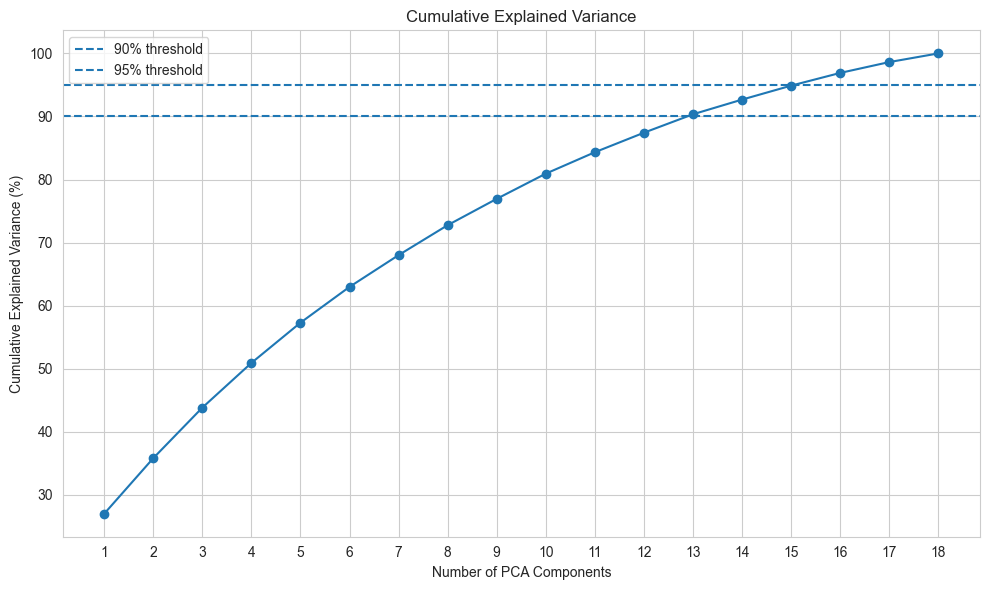

✅ 90% variance: 13 components
✅ 95% variance: 16 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/combined/ses1_figures\b_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


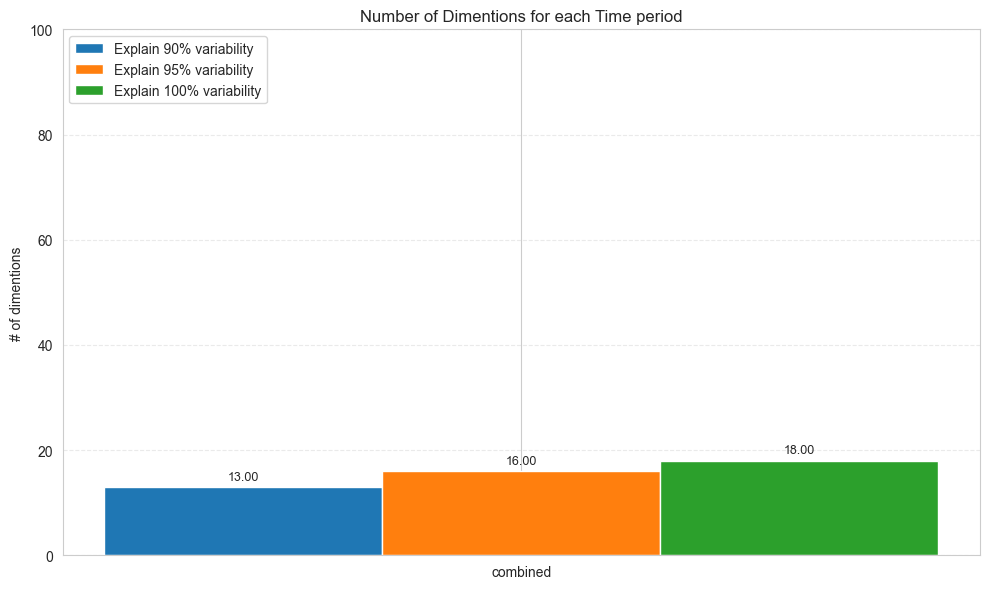

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Number of Dimentions for each Time period'}, ylabel='# of dimentions'>)

In [10]:
n_dims_comb_90, n_dims_comb_95, n_dims_comb_100 = find_optimal_pca_dimensions(q_before,save_dir="data/only_Q_outputs/combined/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_comb_90}")
groups = ["combined"]
s1 = [n_dims_comb_90]  # values for column 1 in each
s2 = [n_dims_comb_95]  # values for column 2
s3 = [n_dims_comb_100]  # values for column 2

plot_grouped_bars(groups, s1, s2, s3,
                  s1_label="Explain 90% variability",
                  s2_label="Explain 95% variability",
                  s3_label="Explain 100% variability",
                  title="Number of Dimentions for each Time period",
                  ylabel="# of dimentions")



Prefix is empty, selecting 'PHQ_' and 'GAD7_' columns explicitly.
[[-0.75333605 -0.9167544  -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [-0.75333605  0.56173677 -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [-0.75333605 -0.9167544  -0.13033363 ... -0.34070929 -0.84224674
  -0.65256975]
 ...
 [-0.75333605  0.56173677 -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [ 2.00819665  3.51871911  1.91155992 ... -0.34070929  0.47727315
   2.31899353]
 [ 0.6274303   0.56173677 -1.15128041 ... -0.34070929 -0.84224674
   0.83321189]]


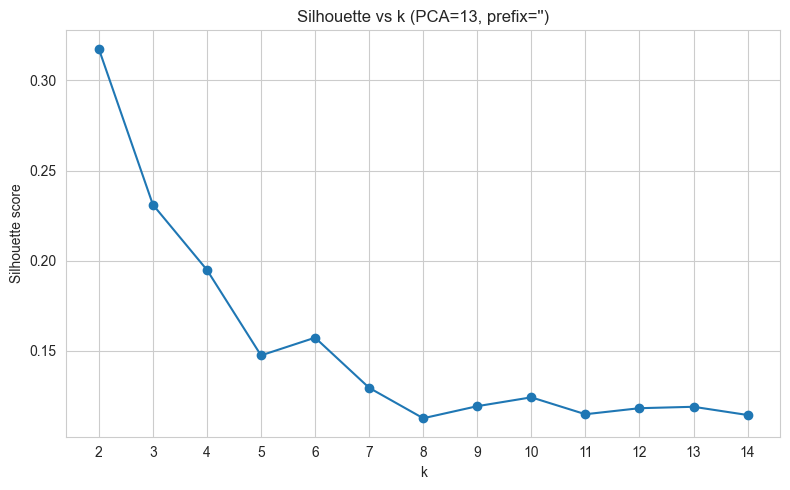


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
    subject_id  cluster  silhouette_sample
0        CT002        1           0.426507
1        CT003        1           0.345538
2        CT004        1           0.486278
3        CT005        1           0.177001
4        CT007        0          -0.056200
..         ...      ...                ...
653      NT123        1           0.485627
654      NT124        1           0.374563
655      NT126        1           0.465284
656      NT129        0           0.237946
657      NT136        0          -0.037150

[658 rows x 3 columns]


In [11]:
# השתמש בפונקציה המתוקנת שהגדרנו למעלה
res_comb = pca_kmeans_minimal_outputs(
    df_combined,
    prefix="",  # עכשיו הפונקציה יודעת לטפל בזה
    n_components=n_dims_comb_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/combined",
    subject_id_col='Subject_Code'  # <--- הוסף את השורה הזו
)

In [12]:
sil_scores_comb = res_comb["sil_scores"]
print("k* =", res_comb["best_k"])


ks = list(range(2, 15))  # same k_range you used in the runs

sil_comb = res_comb["sil_scores"].iloc[:, 0].values


best_k_comb_sil = res_comb["best_k"]

k* = 2


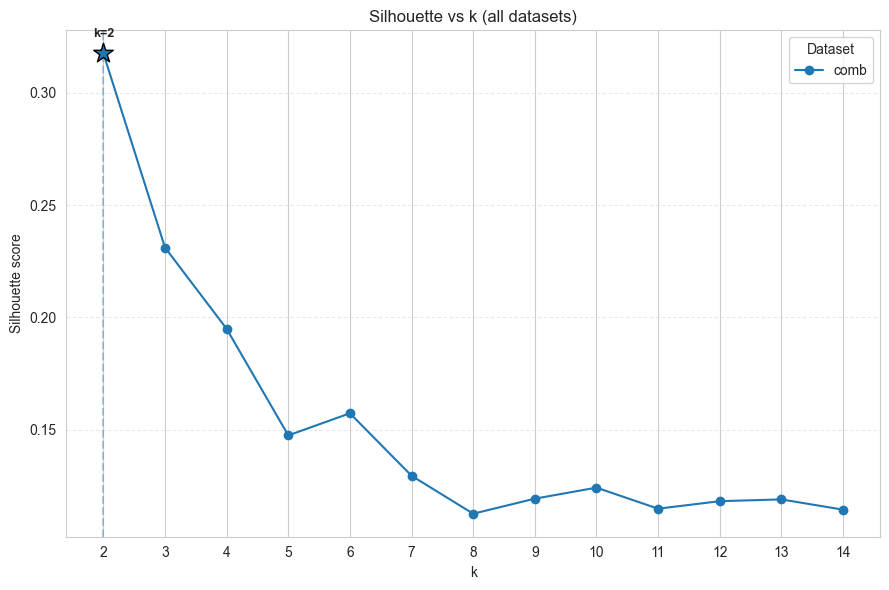

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))

datasets = [
    ("comb", sil_comb, best_k_comb_sil, 'o'),
]

for name, sil, best_k, m in datasets:
    ax.plot(ks, sil, marker=m, label=f"{name}")
    # highlight the chosen k: star + vertical line + label
    i = ks.index(best_k)
    y = sil[i]
    ax.scatter([best_k], [y], s=220, marker='*', edgecolors='black', zorder=5)
    ax.axvline(best_k, linestyle='--', alpha=0.35)
    ax.annotate(f"k={best_k}", xy=(best_k, y),
                xytext=(0, 10), textcoords="offset points",
                ha="center", va="bottom", fontsize=9, weight="bold")

ax.set_title("Silhouette vs k (all datasets)")
ax.set_xlabel("k")
ax.set_ylabel("Silhouette score")
ax.set_xticks(ks)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend(title="Dataset", ncol=2)
plt.tight_layout()
plt.show()

Prefix is empty, selecting 'PHQ_' and 'GAD7_' columns explicitly.
[[-0.75333605 -0.9167544  -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [-0.75333605  0.56173677 -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [-0.75333605 -0.9167544  -0.13033363 ... -0.34070929 -0.84224674
  -0.65256975]
 ...
 [-0.75333605  0.56173677 -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [ 2.00819665  3.51871911  1.91155992 ... -0.34070929  0.47727315
   2.31899353]
 [ 0.6274303   0.56173677 -1.15128041 ... -0.34070929 -0.84224674
   0.83321189]]

✅ נתוני PCA נשמרו בהצלחה ב: data/only_Q_outputs/combined/combined_pca_components.csv


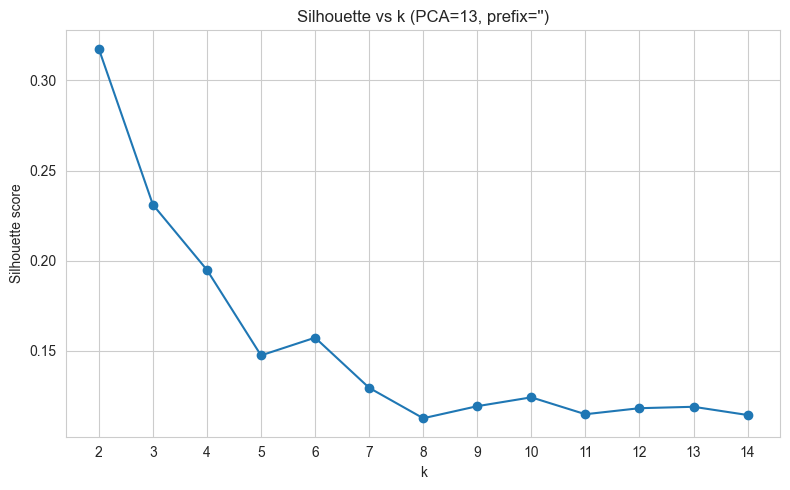


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
    subject_id  cluster  silhouette_sample
0        CT002        1           0.426507
1        CT003        1           0.345538
2        CT004        1           0.486278
3        CT005        1           0.177001
4        CT007        0          -0.056200
..         ...      ...                ...
653      NT123        1           0.485627
654      NT124        1           0.374563
655      NT126        1           0.465284
656      NT129        0           0.237946
657      NT136        0          -0.037150

[658 rows x 3 columns]


In [14]:
# הגדרת נתיב ושם קובץ לנתוני ה-PCA
pca_save_path = "data/only_Q_outputs/combined/combined_pca_components.csv"

res_comb = pca_kmeans_minimal_outputs(
    df_combined,
    prefix="",
    n_components=n_dims_comb_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/combined",
    subject_id_col='Subject_Code',  # <-- הוספנו (תיקון מהפעם הקודמת)
    save_pca_csv=pca_save_path      # <-- הוספנו את הנתיב החדש
)

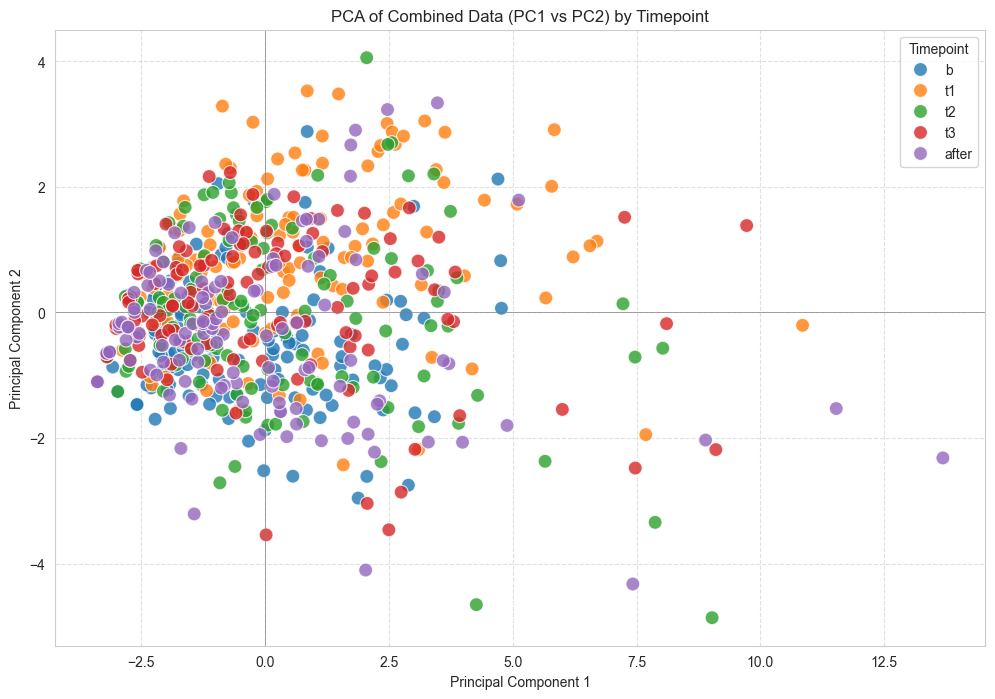

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA שיצרנו
pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"

# 2. טעינת הנתונים
try:
    pca_df = pd.read_csv(pca_file_path)
except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
    print("אנא ודא שהרצת את השלב הקודם ששומר את קובץ ה-PCA.")
    # raise

# 3. יצירת הגרף עם Seaborn
if 'pca_df' in locals(): # בודק אם ה-DataFrame נטען בהצלחה
    plt.figure(figsize=(12, 8)) # קביעת גודל הגרף

    # --- התיקון כאן ---
    # הסרנו את style='timepoint'
    sns.scatterplot(
        data=pca_df,
        x='PC1',              # רכיב עיקרי 1 על ציר X
        y='PC2',              # רכיב עיקרי 2 על ציר Y
        hue='timepoint',      # קביעת הצבע לפי עמודת 'timepoint'
        s=100,                # גודל הנקודות
        alpha=0.8             # שקיפות הנקודות
    )

    # 4. הוספת כותרות ושיפורים
    plt.title('PCA of Combined Data (PC1 vs PC2) by Timepoint')
    plt.xlabel(f'Principal Component 1')
    plt.ylabel(f'Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Timepoint')
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    # 5. הצגת הגרף
    plt.show()

נמצאו 79 נבדקים המופיעים 5 פעמים. הם יודגשו בצבע.

הגרף נשמר בהצלחה ב: data/only_Q_outputs/combined/pca_plot_by_subject_5_times.png


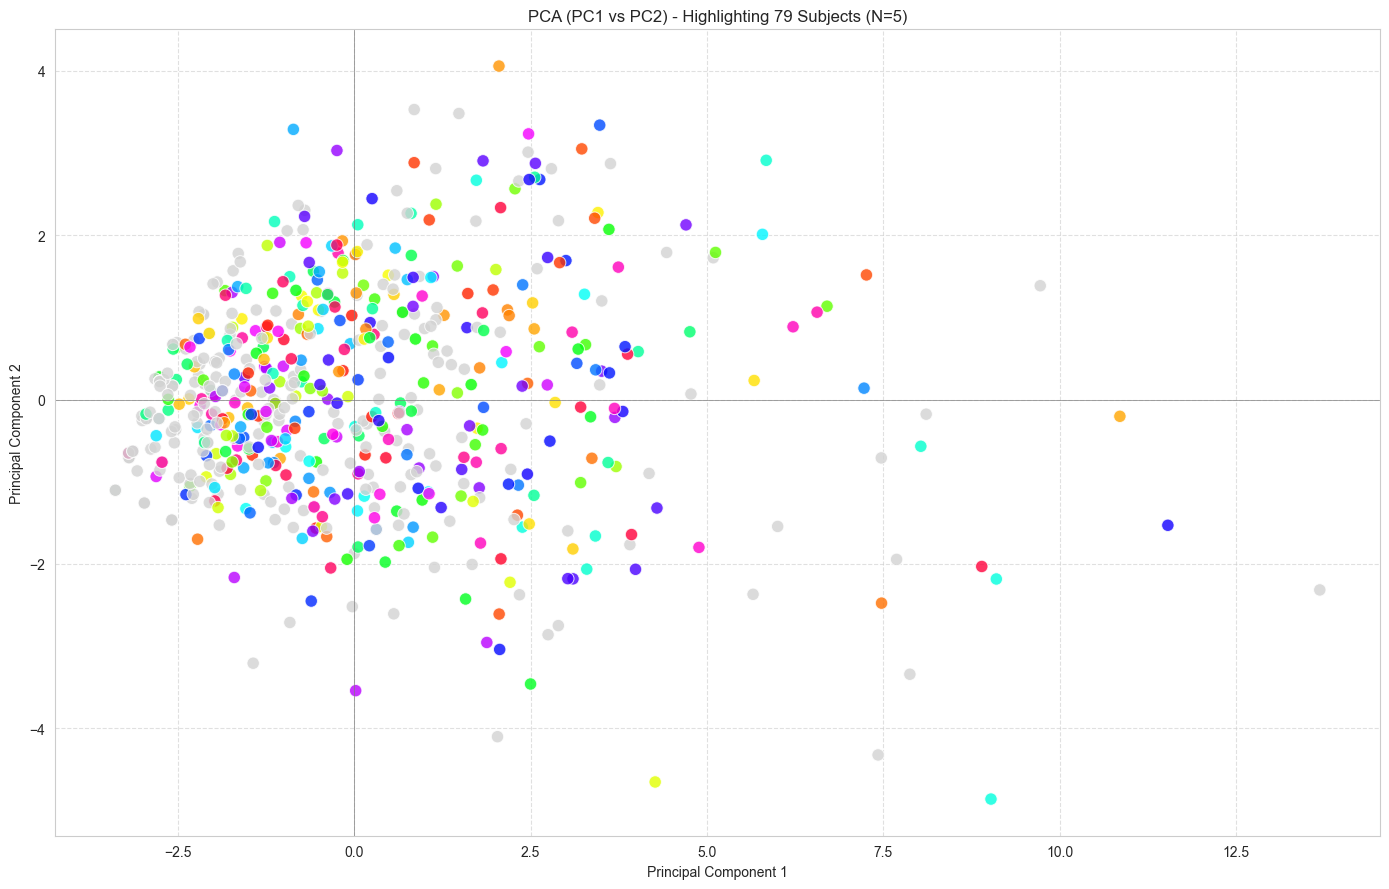

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA
pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"
save_path = "data/only_Q_outputs/combined/pca_plot_by_subject_5_times.png"

try:
    # 2. טעינת הנתונים
    pca_df = pd.read_csv(pca_file_path)

    # 3. זיהוי הנבדקים שמופיעים 5 פעמים
    # ספירת מופעים לכל נבדק
    subject_counts = pca_df['Subject_Code'].value_counts()

    # יצירת רשימה של שמות הנבדקים שמופיעים בדיוק 5 פעמים
    subjects_to_highlight = subject_counts[subject_counts == 5].index.tolist()

    if not subjects_to_highlight:
        print("לא נמצאו נבדקים המופיעים בדיוק 5 פעמים.")
    else:
        print(f"נמצאו {len(subjects_to_highlight)} נבדקים המופיעים 5 פעמים. הם יודגשו בצבע.")

    # 4. יצירת עמודת צביעה חדשה
    # ניצור עמודה ששומרת את שם הנבדק (אם הוא ברשימה) או 'Other' (אם לא)

    other_label = 'Other (N != 5)'

    def get_color_group(subject_code):
        if subject_code in subjects_to_highlight:
            return subject_code  # השאר את שם הנבדק
        else:
            return other_label # סמן כ"אחר"

    # החלת הפונקציה ליצירת העמודה החדשה
    pca_df['color_group'] = pca_df['Subject_Code'].apply(get_color_group)

    # 5. יצירת פלטת צבעים מותאמת
    # אנחנו רוצים שהקבוצה 'Other' תהיה אפורה, והשאר יהיו צבעוניים

    unique_groups = pca_df['color_group'].unique().tolist()
    palette_dict = {}

    # חישוב מספר הצבעים שנצטרך
    num_highlighted = len(unique_groups) - (1 if other_label in unique_groups else 0)

    if num_highlighted > 0:
        # שימוש בפלטת צבעים מגוונת (hsv) כי יש 79 נבדקים
        colors = sns.color_palette('hsv', n_colors=num_highlighted)
    else:
        colors = []

    color_idx = 0
    for group in unique_groups:
        if group == other_label:
            palette_dict[group] = 'lightgrey' # צבע אפור בהיר לרקע
        else:
            palette_dict[group] = colors[color_idx]
            color_idx += 1

    # 6. יצירת הגרף
    plt.figure(figsize=(14, 9))

    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='color_group',    # צביעה לפי הקבוצה החדשה שיצרנו
        palette=palette_dict, # שימוש בפלטת הצבעים המותאמת
        s=80,
        alpha=0.8,
        legend=False          # <-- החלטנו לא להציג את המקרא כי 79 שמות זה יותר מדי
    )

    # 7. הוספת כותרות ושיפורים
    plt.title(f'PCA (PC1 vs PC2) - Highlighting {len(subjects_to_highlight)} Subjects (N=5)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    plt.tight_layout() # התאמה אוטומטית של הגבולות

    # 8. שמירת הגרף
    plt.savefig(save_path, dpi=150)
    print(f"\nהגרף נשמר בהצלחה ב: {save_path}")

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
except Exception as e:
    print(f"אירעה שגיאה: {e}")

In [17]:
import pandas as pd

pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"

try:
    pca_df = pd.read_csv(pca_file_path)

    # זיהוי הנבדקים שמופיעים 5 פעמים
    subject_counts = pca_df['Subject_Code'].value_counts()
    subjects_with_5 = subject_counts[subject_counts == 5].index.tolist()

    print(f"--- רשימת {len(subjects_with_5)} הנבדקים לבחירה (מופיעים 5 פעמים) ---")
    # הדפסת הרשימה בפורמט שקל להעתיק
    print(subjects_with_5)

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")

--- רשימת 79 הנבדקים לבחירה (מופיעים 5 פעמים) ---
['CT003', 'CT004', 'CT005', 'CT007', 'CT010', 'CT008', 'CT012', 'CT013', 'CT051', 'CT015', 'CT022', 'CT027', 'CT026', 'CT025', 'CT024', 'CT023', 'CT029', 'CT028', 'CT050', 'CT039', 'CT038', 'CT034', 'CT033', 'CT031', 'CT044', 'CT046', 'CT041', 'NT018', 'NT023', 'NT022', 'NT025', 'NT024', 'NT033', 'NT005', 'NT010', 'NT007', 'NT002', 'NT001', 'CT061', 'CT058', 'NT082', 'NT069', 'NT060', 'NT058', 'NT063', 'NT065', 'NT123', 'NT126', 'NT094', 'NT096', 'NT097', 'NT100', 'NT090', 'NT017', 'NT016', 'NT015', 'NT034', 'NT030', 'NT027', 'NT028', 'NT077', 'NT081', 'NT074', 'NT055', 'NT047', 'NT048', 'NT049', 'NT046', 'NT042', 'NT040', 'NT039', 'NT036', 'NT129', 'NT136', 'NT118', 'NT124', 'NT089', 'NT091', 'NT085']


הנבדקים שנבחרו ידנית להדגשה: ['CT003', 'CT039', 'CT058', 'NT046', 'NT061', 'NT085', 'NT018', 'CT050', 'CT100', 'CT004']

הגרף נשמר בהצלחה ב: data/only_Q_outputs/combined/pca_plot_10_manual_subjects.png


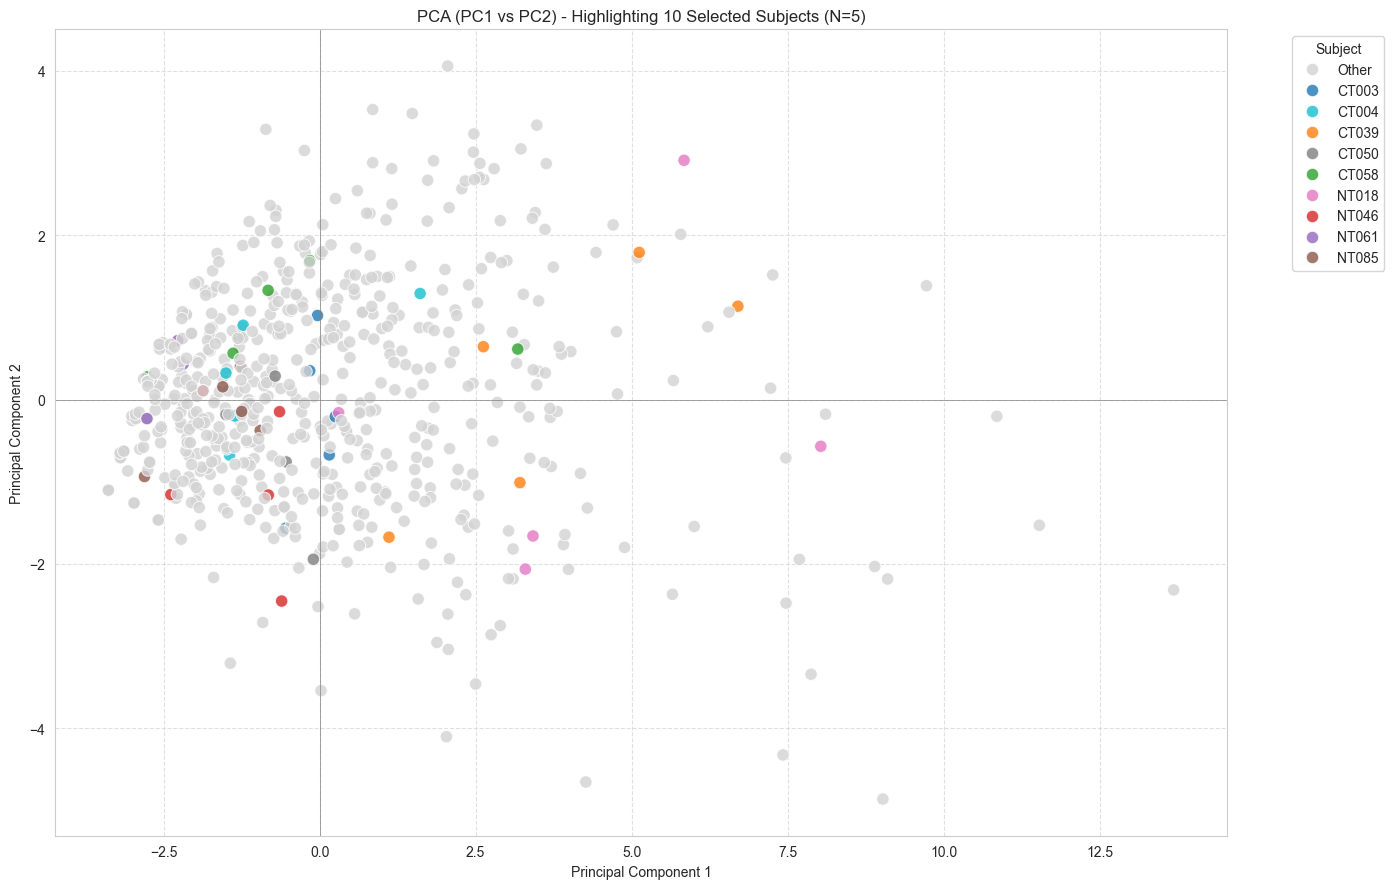

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA
pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"
save_path = "data/only_Q_outputs/combined/pca_plot_10_manual_subjects.png"

try:
    # 2. טעינת הנתונים
    pca_df = pd.read_csv(pca_file_path)

    # ==========================================================
    #               👇 כאן להדביק את הבחירה שלך 👇
    # ==========================================================

    # 💡 הוראות:
    # העתק 10 שמות מהרשימה שהודפסה בשלב 1
    # והדבק אותם כאן. למשל:
    # ['NT085', 'NT015', 'CT061', 'NT002', 'NT030', 'NT126', 'NT039', 'CT029', 'CT008', 'CT013']

    subjects_to_highlight = [
        # הדבק כאן 10 שמות, כל אחד במרכאות ומופרד בפסיק
        'CT003', 'CT039', 'CT058', 'NT046', 'NT061',
        'NT085', 'NT018', 'CT050', 'CT100', 'CT004'
    ]

    # ==========================================================
    #               👆 סוף אזור הבחירה 👆
    # ==========================================================

    print(f"הנבדקים שנבחרו ידנית להדגשה: {subjects_to_highlight}")

    # 5. יצירת עמודת צביעה חדשה
    other_label = 'Other'

    def get_color_group(subject_code):
        if subject_code in subjects_to_highlight:
            return subject_code  # השאר את שם הנבדק
        else:
            return other_label # סמן כ"אחר"

    pca_df['color_group'] = pca_df['Subject_Code'].apply(get_color_group)

    # 6. יצירת פלטת צבעים מותאמת (10 צבעים + אפור)
    palette_dict = {}
    colors = sns.color_palette("tab10", n_colors=10)

    for i, subject in enumerate(subjects_to_highlight):
        palette_dict[subject] = colors[i]

    palette_dict[other_label] = 'lightgrey'

    # 7. יצירת הגרף
    plt.figure(figsize=(14, 9))

    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='color_group',    # צביעה לפי הקבוצה החדשה
        palette=palette_dict, # שימוש בפלטת הצבעים המותאמת
        s=80,
        alpha=0.8,
        legend='full'         # הפעם נציג את המקרא
    )

    # 8. הוספת כותרות ושיפורים
    plt.title(f'PCA (PC1 vs PC2) - Highlighting 10 Selected Subjects (N=5)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # 9. שמירת הגרף
    plt.savefig(save_path, dpi=150)
    print(f"\nהגרף נשמר בהצלחה ב: {save_path}")

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
except Exception as e:
    print(f"אירעה שגיאה: {e}")

Cluster assignments saved to data/only_Q_outputs/combined/clusters_combined.csv


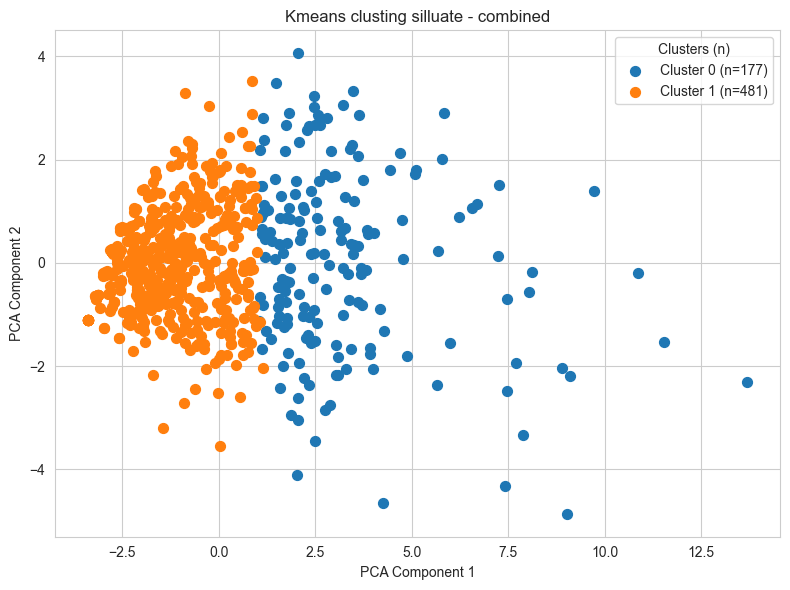

אירעה שגיאה: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


In [19]:

labels_comb_sil, data_pca_comb_sil, model_comb_sil, pca_comb_sil = run_kmeans_clustering(
    df=df_combined,
    prefix="",  # your prefix
    n_components=n_dims_comb_90,
    k=best_k_comb_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - combined",
    csv_path="data/only_Q_outputs/combined/clusters_combined.csv")



# 1. הגדרת נתיבי הקבצים
pca_data_path = "data/only_Q_outputs/combined/combined_pca_components.csv"
cluster_data_path = "data/only_Q_outputs/combined/clusters_combined.csv"

# נתיב שמירה חדש לטבלת הסיכום
summary_save_path = "data/only_Q_outputs/combined_no_pca/cluster_timepoint_summary.csv"

try:
    # 2. טעינת שני קבצי התוצאות
    pca_df = data_pca_comb_sil
    cluster_df = pd.read_csv(cluster_data_path)

    # 3. מיזוג הקבצים
    merged_df = pd.merge(
        pca_df[['Subject_Code', 'timepoint', 'PC1', 'PC2']],
        cluster_df[['Subject_Code', 'timepoint', 'cluster']],
        on=['Subject_Code', 'timepoint']
    )

    # ==========================================================
    #         👇 הוספת הקוד לסיכום הנתונים 👇
    # ==========================================================

    # 4. יצירת טבלת הסיכום (crosstab)
    #    האשכולות יהיו השורות, ונקודות הזמן יהיו העמודות
    summary_table = pd.crosstab(
        index=merged_df['cluster'],     # השורות
        columns=merged_df['timepoint'], # העמודות
        margins=True,                   # הוסף שורת ועמודת "סך הכל"
        margins_name="Total"            # קרא לסך הכל "Total"
    )

    # 5. הדפסת הטבלה למסך
    print("--- סיכום נבדקים: אשכול מול נקודת זמן ---")
    print(summary_table)

    # 6. שמירת הטבלה לקובץ CSV
    summary_table.to_csv(summary_save_path)
    print(f"\nטבלת הסיכום נשמרה ב: {summary_save_path}")

    # ==========================================================
    #                  👆 סוף הקוד לסיכום 👆
    # ==========================================================

    # (הקוד הקודם לשרטוט הגרף יכול להמשיך מכאן אם תרצה)

except FileNotFoundError as e:
    print(f"שגיאה: הקובץ לא נמצא. אנא ודא ששני הקבצים קיימים בנתיבים הנכונים.")
    print(e)
except Exception as e:
    print(f"אירעה שגיאה: {e}")

נמצאו נקודות זמן ייחודיות: ['b' 't1' 't2' 't3' 'after']

  Running clustering for timepoint: b
Cluster assignments saved to data/only_Q_outputs/combined/clusters_b.csv


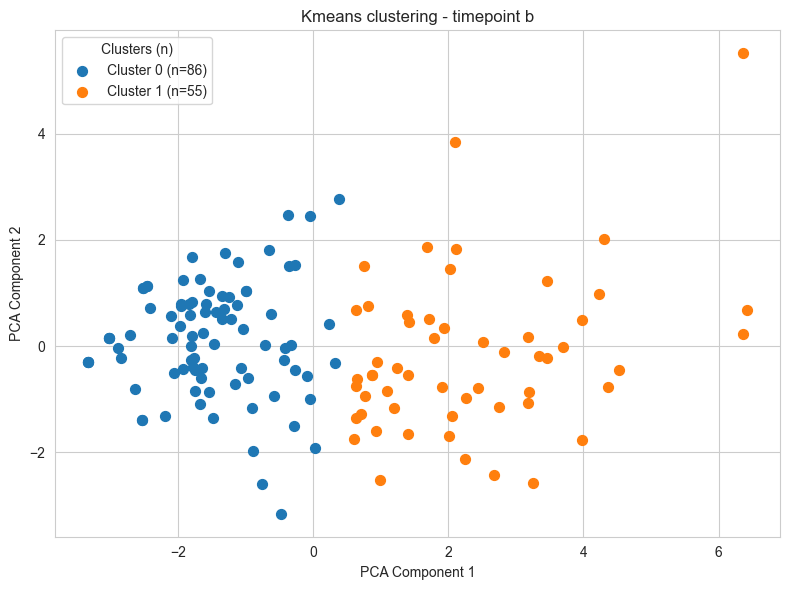


  Running clustering for timepoint: t1
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t1.csv


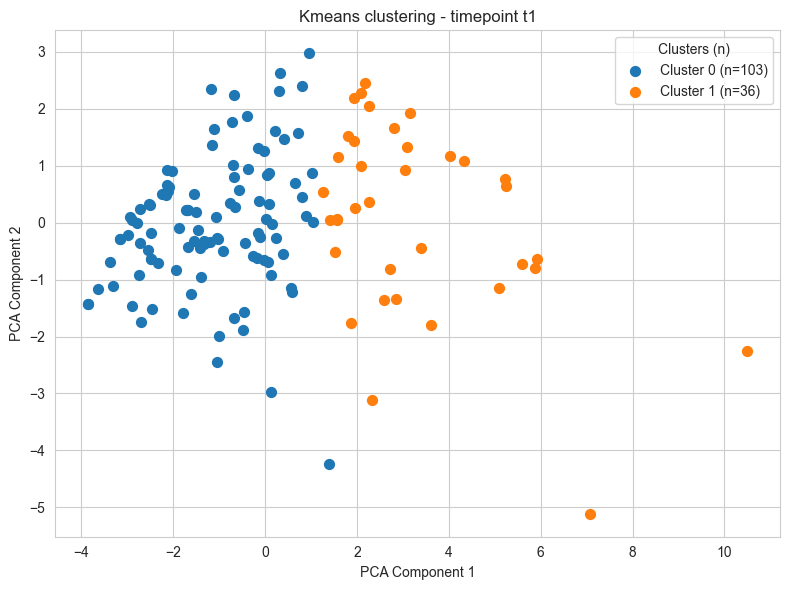


  Running clustering for timepoint: t2
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t2.csv


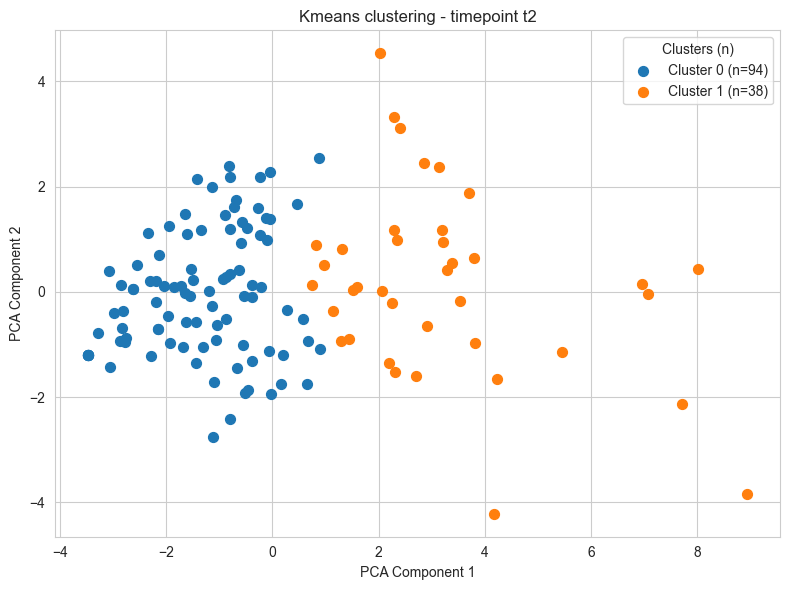


  Running clustering for timepoint: t3
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t3.csv


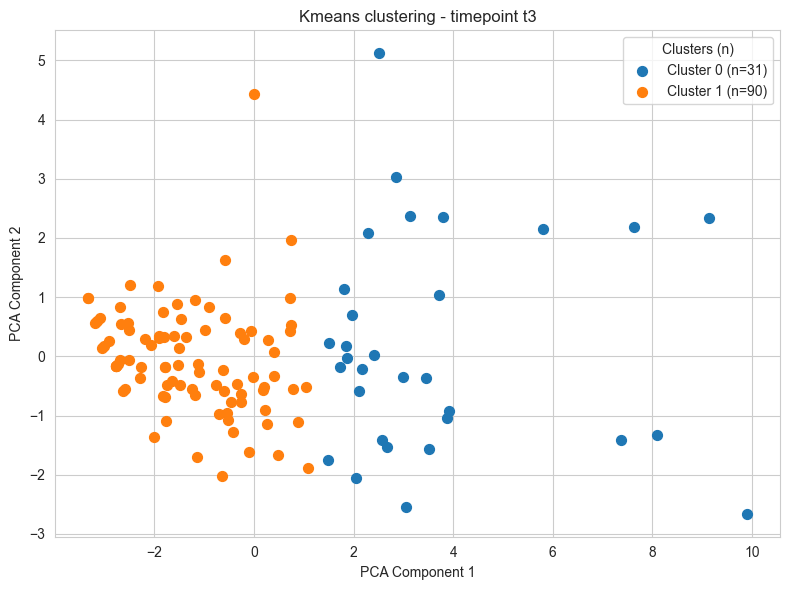


  Running clustering for timepoint: after
Cluster assignments saved to data/only_Q_outputs/combined/clusters_after.csv


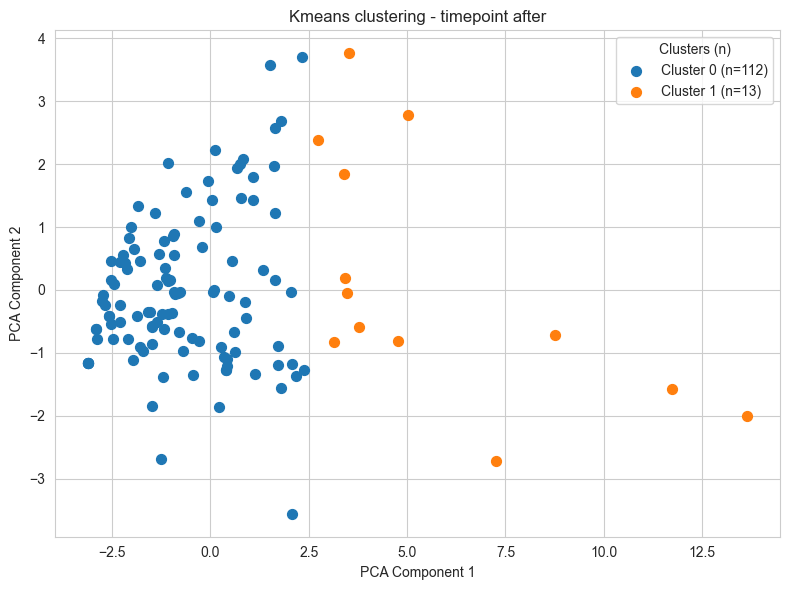


✅ All timepoints processed.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- (כאן צריכה להיות הפונקציה שלך run_kmeans_clustering) ---
# def run_kmeans_clustering(....):
#     ...

# 1. מציאת כל נקודות הזמן הייחודיות
timepoints = df_combined['timepoint'].unique()
print(f"נמצאו נקודות זמן ייחודיות: {timepoints}")

# 2. יצירת מילון (dict) לאחסון התוצאות
results_by_timepoint = {}

# 3. הרצת הלולאה על כל נקודת זמן
for tp in timepoints:
    print(f"\n=============================================")
    print(f"  Running clustering for timepoint: {tp}")
    print(f"=============================================")

    # 4. סינון ה-DataFrame הראשי רק לנקודת הזמן הנוכחית
    df_t = df_combined[df_combined['timepoint'] == tp].copy()

    # 5. הגדרת שמות ומיקומים ייחודיים לכל ריצה
    csv_path_t = f"data/only_Q_outputs/combined/clusters_{tp}.csv"
    title_t = f"Kmeans clustering - timepoint {tp}"

    # 6. קריאה לפונקציה שלך עם הנתונים המסוננים
    labels_t, data_pca_t, model_t, pca_t = run_kmeans_clustering(
        df=df_t,
        prefix="",  # עדיין משתמשים ב-"" לבחירת עמודות PHQ/GAD
        n_components=n_dims_comb_90, # ⚠️ ראה הערה למטה
        k=best_k_comb_sil,           # ⚠️ ראה הערה למטה
        plot=True,
        title=title_t,
        csv_path=csv_path_t
    )

    # 7. שמירת התוצאות במילון
    results_by_timepoint[tp] = {
        'labels': labels_t,
        'data_pca': data_pca_t,
        'model': model_t,
        'pca': pca_t
    }

print("\n✅ All timepoints processed.")

--- Running clustering for ALL timepoints combined ---
Cluster assignments saved to data/only_Q_outputs/combined/clusters_ALL_combined.csv


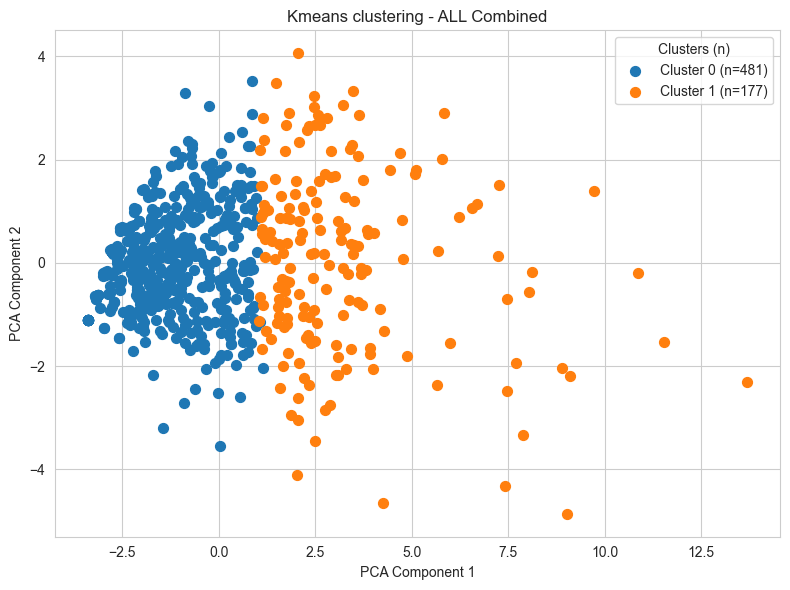


--- Running clustering for EACH timepoint ---

================ Running for timepoint: b ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_b.csv


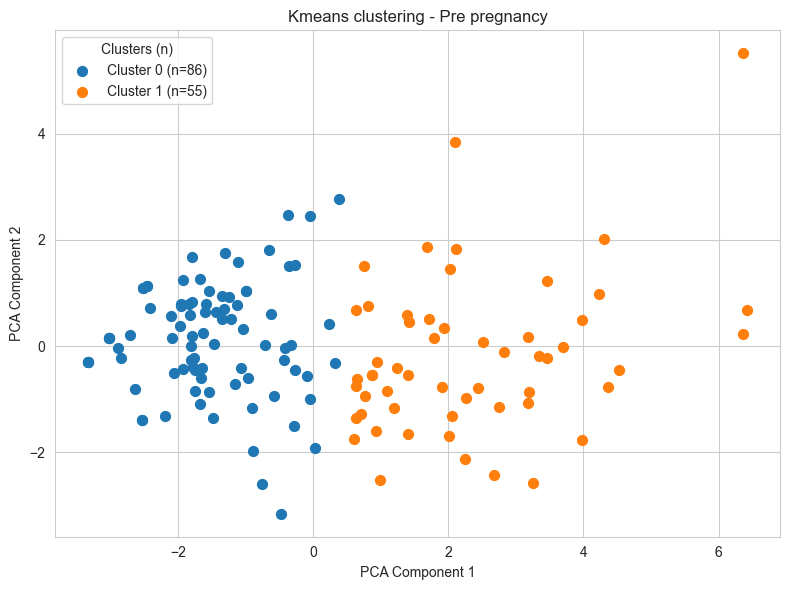


================ Running for timepoint: t1 ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t1.csv


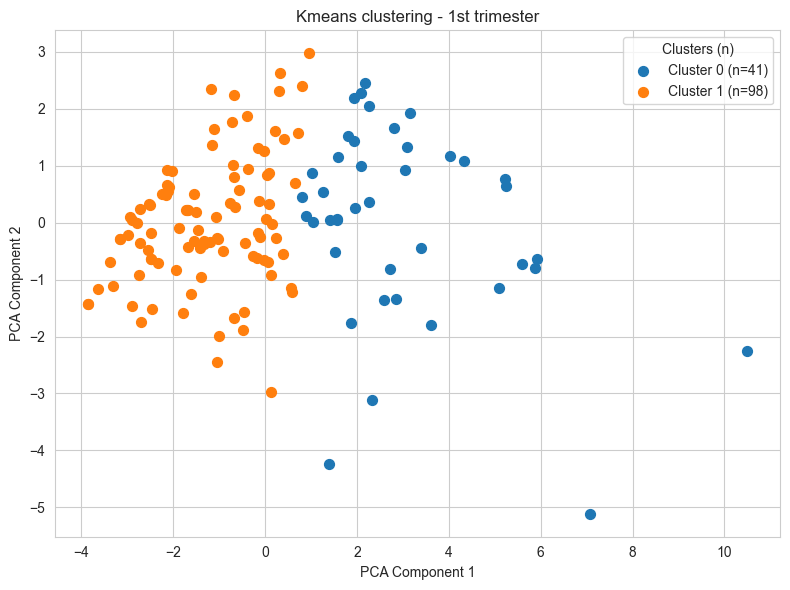


================ Running for timepoint: t2 ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t2.csv


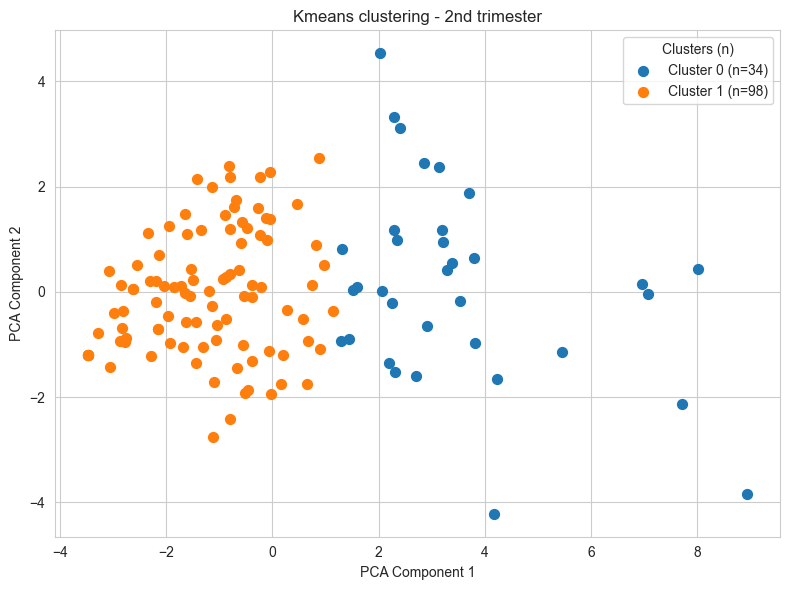


================ Running for timepoint: t3 ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t3.csv


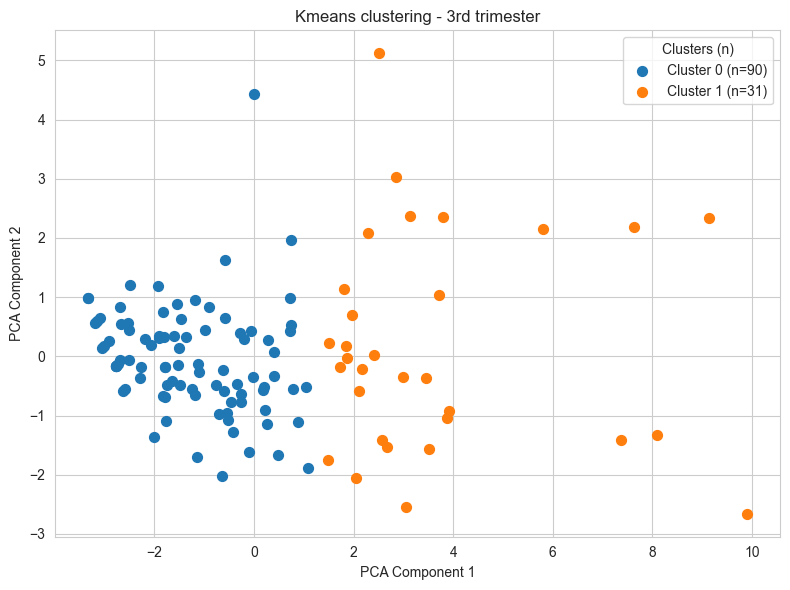


================ Running for timepoint: after ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_after.csv


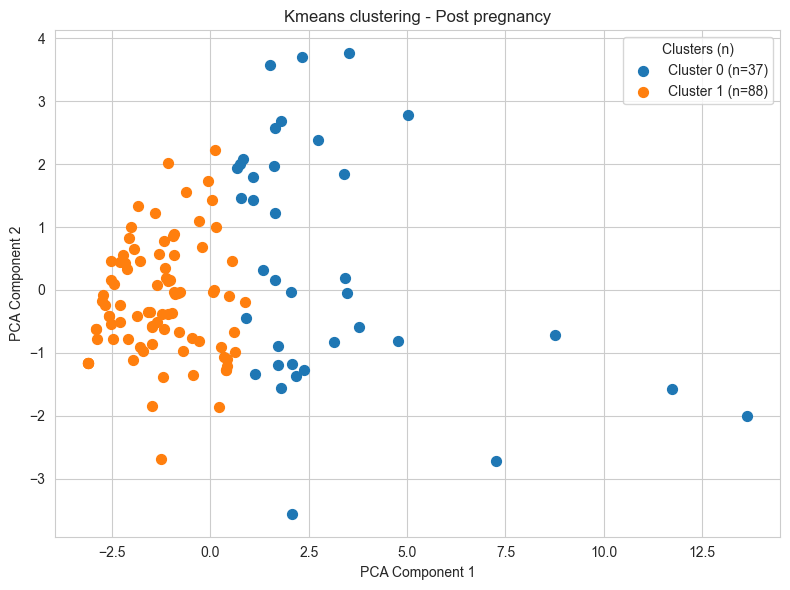


✅ All timepoints processed.
--- Generating final 2x3 combined plot ---


C:\Users\nogag\AppData\Local\Temp\ipykernel_23900\865060318.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


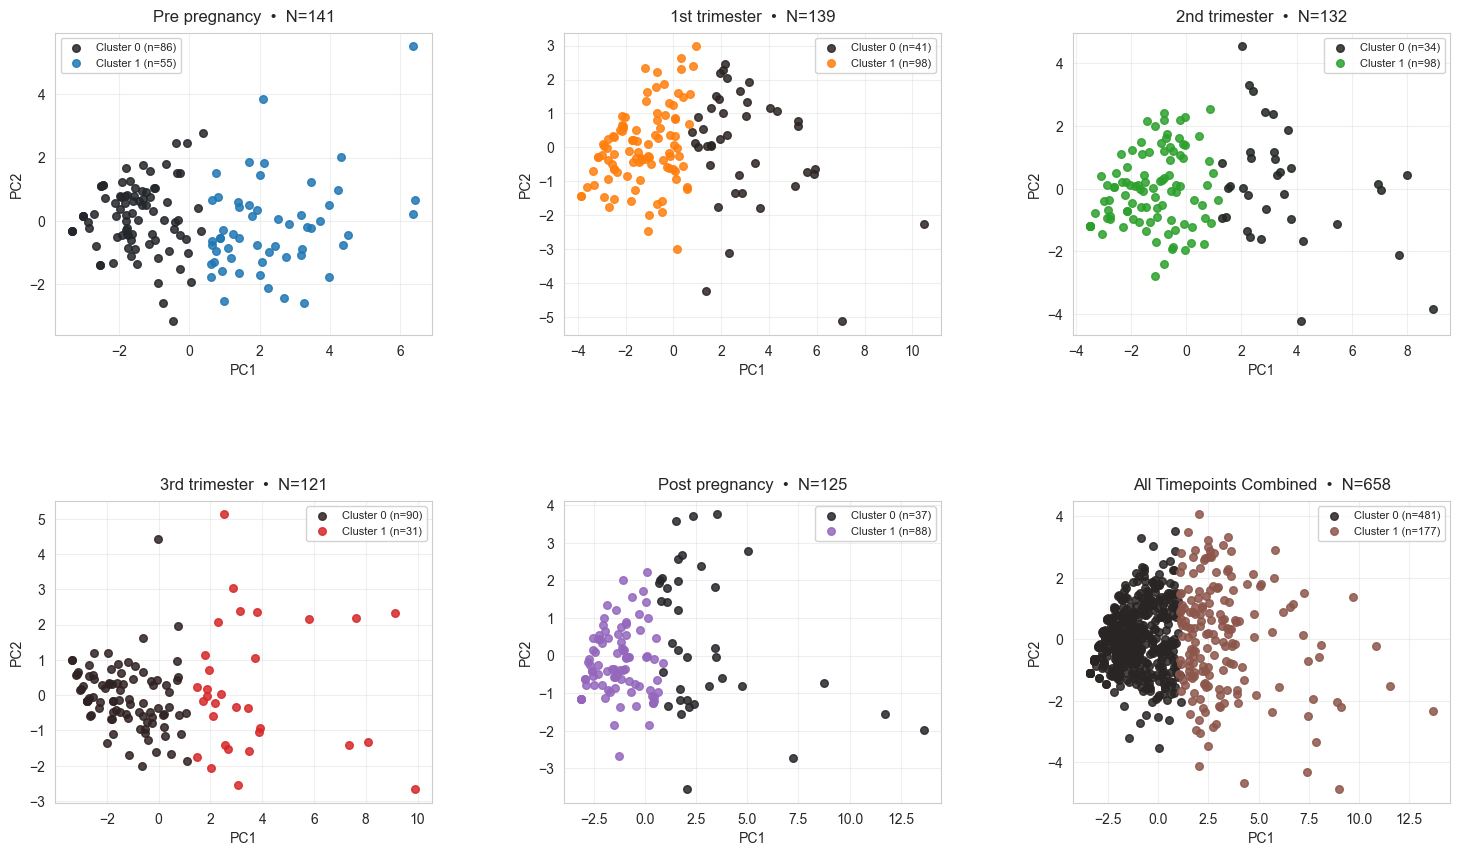

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math
import seaborn as sns # נדרש עבור _pick_palette_for_labels

# ===================================================================
#           חלק 1: הגדרת כל הפונקציות הנדרשות
# ===================================================================

# --- פונקציית עזר 1 (נדרשת ע"י פונקציית השרטוט) ---
def _auto_layout(n, max_cols=3):
    """Calculates the number of rows and columns for subplots."""
    nrows = math.ceil(n / max_cols)
    ncols = min(n, max_cols)
    return nrows, ncols

# --- פונקציית עזר 2 (נדרשת ע"י פונקציית השרטוט) ---
def _pick_palette_for_labels(base_color, unique_labels):
    """Creates a color palette for a set of labels."""
    n_colors = len(unique_labels)
    if n_colors == 1:
        return {unique_labels[0]: base_color}
    try:
        # שימוש בפלטה כהה כדי להבדיל אשכולות
        colors = sns.dark_palette(base_color, n_colors=n_colors)
        return {lab: color for lab, color in zip(unique_labels, colors)}
    except Exception:
        # Fallback
        colors = sns.color_palette(n_colors=n_colors)
        return {lab: color for lab, color in zip(unique_labels, colors)}



    return labels, data_pca, kmeans, pca

# --- פונקציה 2: שרטוט מרובה פאנלים (כפי שסיפקת) ---
def plot_multi_dataset_scatters_colored(
    datasets,
    titles=None,
    labels_list=None,
    x_idx=0,
    y_idx=1,
    figsize=(18, 10),
    point_size=30,
    alpha=0.85,
    base_colors=None,
    wspace=0.35,
    hspace=0.55,
    axes_bg="white",
    max_cols=3,
    legend_loc="best",
    sort_labels=True,
    show_counts=True,
    show_percent=False
):
    """
    Draw multiple PCA scatter panels, coloring by clusters. Adds cluster counts to legend.
    """
    n = len(datasets)
    if base_colors is None:
        base_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                       "tab:purple", "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]

    if len(base_colors) < n:
        cycles_needed = math.ceil(n / len(base_colors))
        base_colors = (base_colors * cycles_needed)[:n]

    nrows, ncols = _auto_layout(n, max_cols=max_cols)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=figsize,
        gridspec_kw={"wspace": wspace, "hspace": hspace}
    )
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for i, data in enumerate(datasets):
        ax = axes[i]
        ax.set_facecolor(axes_bg)

        # בדיקה אם הנתונים קיימים (למקרה של שגיאה בריצה)
        if data is None or labels_list[i] is None:
            ax.text(0.5, 0.5, f"No data for {titles[i] if titles else ''}",
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, color='red')
            ax.set_title(titles[i] if titles else '', pad=8)
            continue

        labels = labels_list[i]
        x = data[:, x_idx]
        y = data[:, y_idx]

        labels = np.asarray(labels)
        unique_labels = [lab for lab in np.unique(labels) if lab == lab] # Handles NaNs
        if sort_labels:
            try: unique_labels = np.sort(unique_labels)
            except Exception: pass

        total_n = int(np.sum(~np.isnan(labels))) if np.issubdtype(labels.dtype, np.floating) else len(labels)
        palette = _pick_palette_for_labels(base_colors[i], unique_labels)

        for lab in unique_labels:
            mask = labels == lab
            n_lab = int(np.sum(mask))
            if n_lab == 0: continue
            legend_text = f"Cluster {lab}"
            if show_counts:
                if show_percent and total_n > 0:
                    legend_text += f" (n={n_lab}, {n_lab/total_n:.0%})"
                else:
                    legend_text += f" (n={n_lab})"

            ax.scatter(
                x[mask], y[mask],
                s=point_size, alpha=alpha,
                color=palette[lab], label=legend_text
            )

        ax.legend(fontsize=8, frameon=True, framealpha=0.85, loc=legend_loc)
        ax.set_xlabel(f"PC{x_idx+1}")
        ax.set_ylabel(f"PC{y_idx+1}")
        if titles is not None and i < len(titles):
            ttl = titles[i]
            ttl = f"{ttl}  •  N={total_n}" if show_counts else ttl
            ax.set_title(ttl, pad=8)
        ax.grid(alpha=0.3)

    # כיבוי צירים ריקים (אם יש 6 פאנלים, זה לא יקרה)
    for j in range(len(datasets), nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show() # הצגת הגרף המאוחד

# ===================================================================
#           חלק 2: הרצת הניתוח
# ===================================================================

# --- שלב א': הרצת האשכולות על כל הנתונים (עבור הפאנל ה-6) ---
print("--- Running clustering for ALL timepoints combined ---")
# (אני מניח שהמשתנים n_dims_comb_90 ו- best_k_comb_sil קיימים אצלך)
# (שים לב: plot=True כאן יציג את הגרף המשולב *בנפרד* בפעם הראשונה)
labels_comb_sil, data_pca_comb_sil, model_comb_sil, pca_comb_sil = run_kmeans_clustering(
    df=df_combined,
    prefix="",
    n_components=n_dims_comb_90,
    k=best_k_comb_sil,
    plot=True, # <-- שנה ל-False אם אינך רוצה לראות גרף זה בנפרד
    title="Kmeans clustering - ALL Combined",
    csv_path="data/only_Q_outputs/combined/clusters_ALL_combined.csv"
)

# --- שלב ב': הרצת הלולאה עבור כל נקודת זמן ---
# הגדרת סדר נקודות הזמן והכותרות
timepoint_map = {
    'b': "Pre pregnancy",
    't1': "1st trimester",
    't2': "2nd trimester",
    't3': "3rd trimester",
    'after': "Post pregnancy"
}
plot_order = ['b', 't1', 't2', 't3', 'after'] # הסדר הרצוי לפאנלים

results_by_timepoint = {}

print("\n--- Running clustering for EACH timepoint ---")
for tp in plot_order:
    if tp not in df_combined['timepoint'].unique():
        print(f"Warning: Timepoint '{tp}' not found in df_combined. Skipping.")
        results_by_timepoint[tp] = {'labels': None, 'data_pca': None} # Placeholder
        continue

    print(f"\n================ Running for timepoint: {tp} ================")
    df_t = df_combined[df_combined['timepoint'] == tp].copy()

    csv_path_t = f"data/only_Q_outputs/combined/clusters_{tp}.csv"
    title_t = f"Kmeans clustering - {timepoint_map[tp]}"

    # (שים לב: plot=True כאן יציג גרף נפרד *לכל* נקודת זמן)
    labels_t, data_pca_t, model_t, pca_t = run_kmeans_clustering(
        df=df_t,
        prefix="",
        n_components=n_dims_comb_90,
        k=best_k_comb_sil,
        plot=True, # <-- שנה ל-False אם אינך רוצה לראות 5 גרפים נפרדים
        title=title_t,
        csv_path=csv_path_t
    )

    results_by_timepoint[tp] = {
        'labels': labels_t,
        'data_pca': data_pca_t
    }

print("\n✅ All timepoints processed.")

# --- שלב ג': איסוף התוצאות והכנה לשרטוט המאוחד ---
print("--- Generating final 2x3 combined plot ---")

# בניית הרשימות עבור פונקציית השרטוט
datasets_to_plot = [results_by_timepoint[tp]['data_pca'] for tp in plot_order]
labels_to_plot = [results_by_timepoint[tp]['labels'] for tp in plot_order]
titles_for_plot = [timepoint_map[tp] for tp in plot_order]

# הוספת הפריט השישי (המשולב)
datasets_to_plot.append(data_pca_comb_sil)
labels_to_plot.append(labels_comb_sil)
titles_for_plot.append("All Timepoints Combined")

# הגדרת 6 צבעי בסיס
base_colors_for_plot = [
    "tab:blue", "tab:orange", "tab:green",
    "tab:red", "tab:purple", "tab:brown"
]

# --- שלב ד': קריאה לפונקציית השרטוט המאוחד ---
plot_multi_dataset_scatters_colored(
    datasets=datasets_to_plot,
    titles=titles_for_plot,
    labels_list=labels_to_plot,
    x_idx=0, y_idx=1,
    base_colors=base_colors_for_plot,
    show_counts=True,
    show_percent=False,
    max_cols=3 # מבטיח גריד של 2x3
)

C:\Users\nogag\AppData\Local\Temp\ipykernel_23900\865060318.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


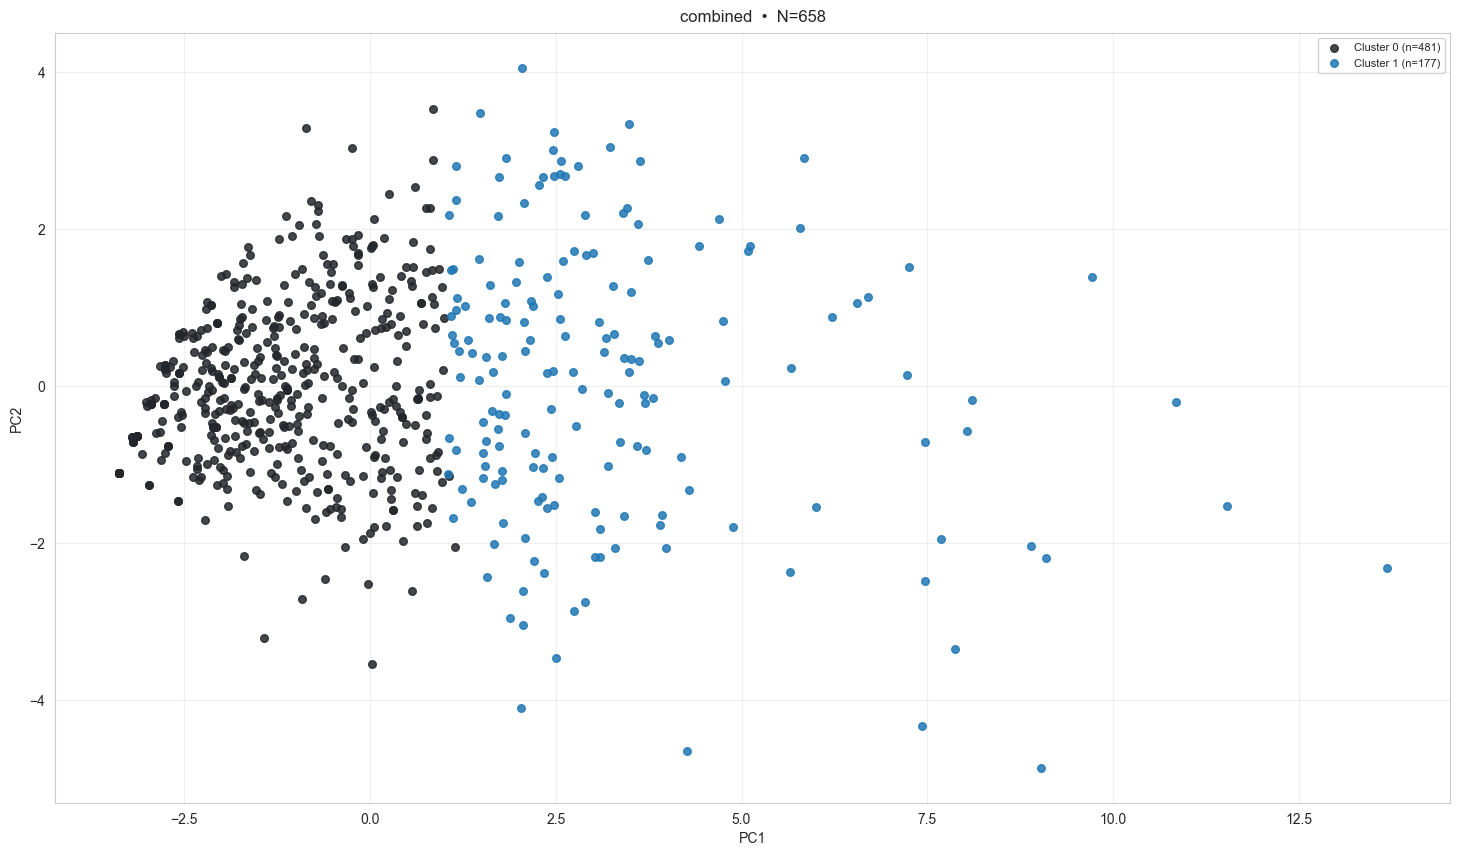

In [22]:
plot_multi_dataset_scatters_colored(
    datasets=[data_pca_comb_sil],
    titles=["combined"],
    labels_list=[labels_comb_sil],
    x_idx=0, y_idx=1,
    base_colors=["tab:blue"],
    show_counts=True,  # <-- on
    show_percent=False  # <-- optional %
)

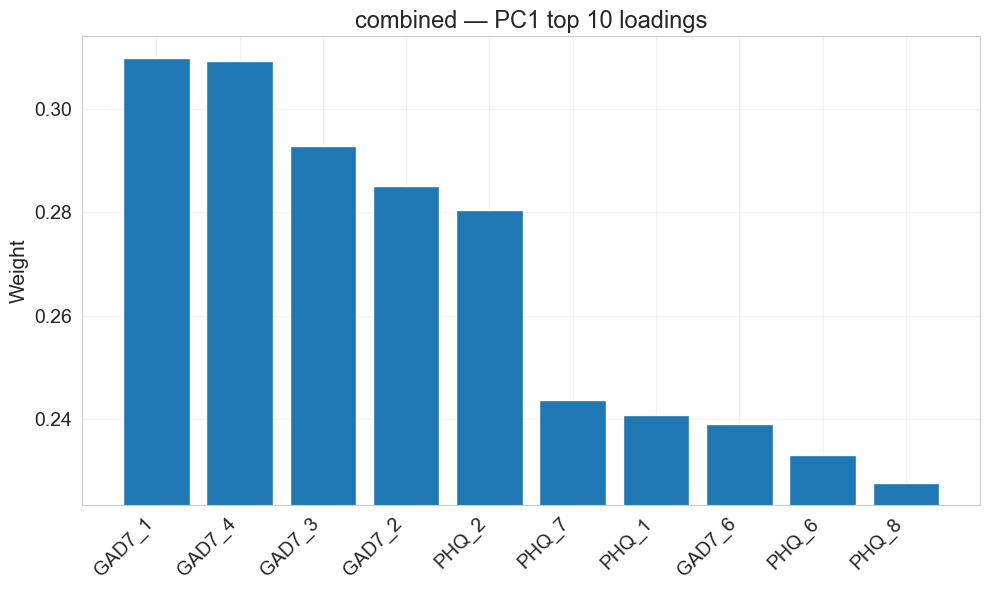

    dataset  pc  rank_within_dataset feature   loading  abs_loading
0  combined   1                    1  GAD7_1  0.309961     0.309961
1  combined   1                    2  GAD7_4  0.309399     0.309399
2  combined   1                    3  GAD7_3  0.292849     0.292849
3  combined   1                    4  GAD7_2  0.285107     0.285107
4  combined   1                    5   PHQ_2  0.280446     0.280446
5  combined   1                    6   PHQ_7  0.243635     0.243635
6  combined   1                    7   PHQ_1  0.240787     0.240787
7  combined   1                    8  GAD7_6  0.239079     0.239079
8  combined   1                    9   PHQ_6  0.233010     0.233010
9  combined   1                   10   PHQ_8  0.227505     0.227505


In [23]:
# PC1 (pc_index=0), top 15:
df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_comb_sil],
    dfs=[df_combined],
    prefixes=[""],
    titles=["combined"],
    pc_index=0,
    top_n=10,
    figsize=(10, 6),
    fontsize=15,
    save_csv_path="data/only_Q_outputs/combined/top_loadings_PC1.csv"  # או "top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

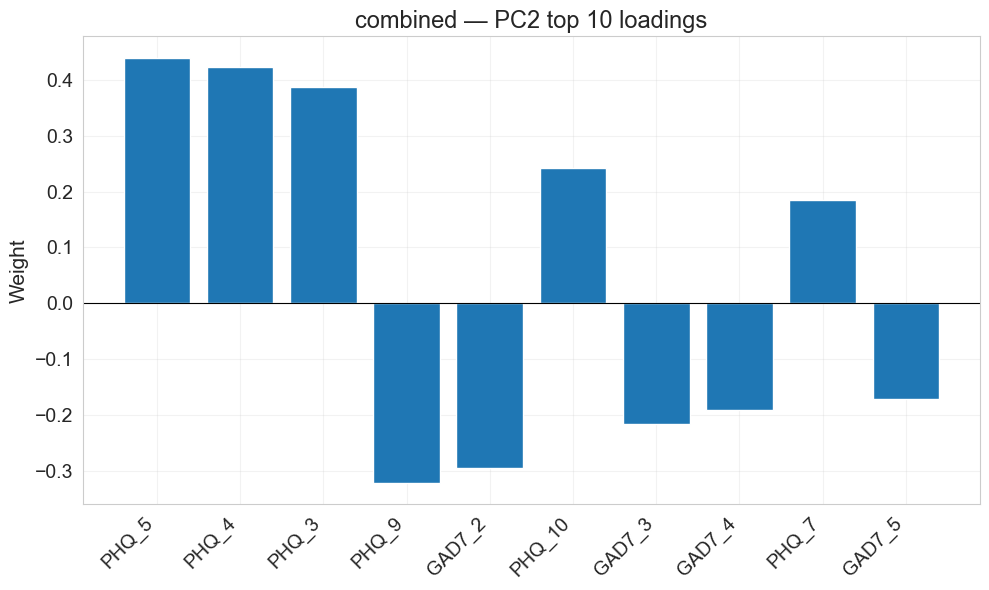

    dataset  pc  rank_within_dataset feature   loading  abs_loading
0  combined   2                    1   PHQ_5  0.440313     0.440313
1  combined   2                    2   PHQ_4  0.422862     0.422862
2  combined   2                    3   PHQ_3  0.387637     0.387637
3  combined   2                    4   PHQ_9 -0.322654     0.322654
4  combined   2                    5  GAD7_2 -0.295180     0.295180
5  combined   2                    6  PHQ_10  0.242477     0.242477
6  combined   2                    7  GAD7_3 -0.216254     0.216254
7  combined   2                    8  GAD7_4 -0.192214     0.192214
8  combined   2                    9   PHQ_7  0.185022     0.185022
9  combined   2                   10  GAD7_5 -0.172280     0.172280


In [24]:
df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_comb_sil],
    dfs=[df_combined],
    prefixes=[""],
    titles=["combined"],
    pc_index=1,
    top_n=10,
    figsize=(10, 6),
    fontsize=15,
    save_csv_path="data/only_Q_outputs/combined/top_loadings_PC1.csv"  # או "top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

columns_to_select = ['b_ctq_total','b_LHQ_total', 'b_DES_average','b_DERS_total', 't1_MAAS_total','t1_DES_total','t2_MAAS_total','t3_MAAS_total'
,'after_MPAS_total','after_DES_total','after_LHQ_total','after_DERS_total',
        "b_ctq_sexual_abuse",
        "b_ctq_physical_abuse",
        "b_ctq_emotional_abuse",
        "b_ctq_physical_neglect",
        "b_ctq_emotional_neglect" ,
        "b_ctq_ABUSE  ",
        "b_ctq_NEGLECT",
        "b_DERS_Nonacceptance_Emotional_Responses",
        "b_DERS_Goal_Directed_Behavior",
        "b_DERS_Impulse_Control",
        "b_DERS_Lack_Emotional_Awareness",
        "b_DERS_Emotion_Regulation_Strategies",
        "b_DERS_Lack_Emotional_Clarity" ,
        "b_DES_Absorption ",
        "b_DES_Amnesia",
        "b_DES_Depersonalization ",
        "after_DERS_Nonacceptance_Emotional_Responses",
        "after_DERS_Goal_Directed_Behavior",
        "after_DERS_Impulse_Control",
        "after_DERS_Lack_Emotional_Awareness",
        "after_DERS_Emotion_Regulation_Strategies",
        "after_DERS_Lack_Emotional_Clarity" ,
        'after_DES_Absorption ',
        'after_DES_Amnesia',
        'after_DES_Depersonalization ','after_CTQ_total',
        "after_CTQ_sexual_abuse",
        "after_CTQ_physical_abuse",
        "after_CTQ_emotional_abuse",
        "after_CTQ_physical_neglect",
        "after_CTQ_emotional_neglect" ,
        "after_CTQ_ABUSE  ",
        "after_CTQ_NEGLECT"]

Data scaled successfully. Shape: (658, 10)
Calculating Silhouette scores for k in [2, 3, 4, 5, 6, 7]...
Silhouette plot saved to data\only_Q_outputs\combined_no_pca\silhouette_vs_k_no_pca.png


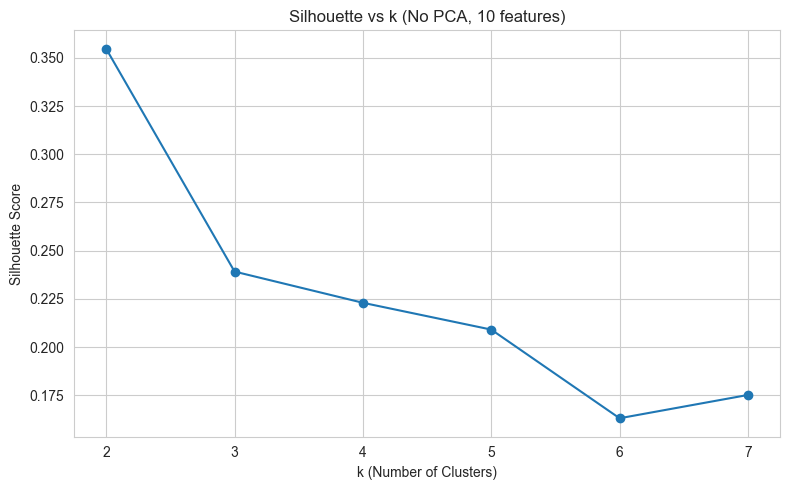


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
Cluster assignments saved to data\only_Q_outputs\combined_no_pca\cluster_assignments_no_pca.csv

--- Cluster Assignments (Head) ---
  Subject_Code timepoint  cluster  silhouette_sample
0        CT002         b        1           0.396634
1        CT003         b        1           0.286165
2        CT004         b        1           0.434615
3        CT005         b        1           0.270682
4        CT007         b        0           0.080072

Best K selected: 2
Assignments saved to: data\only_Q_outputs\combined_no_pca\cluster_assignments_no_pca.csv


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from pathlib import Path

def cluster_on_selected_features(
    df,
    columns_to_keep,          # רשימת העמודות הספציפית שלך!
    k_range=range(2, 11),     # טווח ה-K לבדיקה
    subject_id_col='Subject_Code',
    save_dir=None,            # תיקייה לשמירת התוצאות
    random_state=42
):
    """
    מבצע K-Means ישירות על עמודות נבחרות (ללא PCA).
    כולל מציאת K אופטימלי לפי Silhouette ושמירת התוצאות.
    """

    # 1) בחירת עמודות רלוונטיות
    X = df[columns_to_keep].copy()

    if X.empty:
        raise ValueError("No data found for the selected columns.")

    # 2) ניקוי וסטנדרטיזציה
    # (נשתמש במילוי ממוצע כפי שהיה בפונקציה הקודמת)
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.fillna(X.mean())
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    print(f"Data scaled successfully. Shape: {Xs.shape}")

    # 3) בחירת k לפי סילואט (על הנתונים המנורמלים, לא PCA)
    ks = list(k_range)
    sil_scores = []
    print(f"Calculating Silhouette scores for k in {ks}...")
    for k in ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        lbl = km.fit_predict(Xs)
        sil_scores.append(silhouette_score(Xs, lbl))

    # ציור גרף סילואט
    plt.figure(figsize=(8,5))
    plt.plot(ks, sil_scores, marker='o')
    plt.title(f"Silhouette vs k (No PCA, {len(columns_to_keep)} features)")
    plt.xlabel("k (Number of Clusters)")
    plt.ylabel("Silhouette Score")
    plt.xticks(ks)
    plt.grid(True)

    silhouette_plot_path = None
    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        silhouette_plot_path = Path(save_dir) / "silhouette_vs_k_no_pca.png"
        plt.tight_layout()
        plt.savefig(silhouette_plot_path, dpi=150)
        print(f"Silhouette plot saved to {silhouette_plot_path}")
    plt.show()

    best_k = ks[int(np.argmax(sil_scores))]
    print(f"\n✅ מספר הקלאסטרים שנבחר לפי סילואט: {best_k}")

    # 4) אימון סופי + שיוכי נבדקות
    kmeans = KMeans(n_clusters=best_k, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(Xs)
    sil_each = silhouette_samples(Xs, labels)

    # מציאת עמודות מזהים (נבדק + נקודת זמן)
    id_cols = [subject_id_col]
    if 'timepoint' in df.columns:
        id_cols.append('timepoint')

    assignments = df.loc[X.index, id_cols].copy()
    assignments["cluster"] = labels
    assignments["silhouette_sample"] = sil_each

    # 5) שמירת התוצאות
    assignments_csv_path = None
    if save_dir:
        assignments_csv_path = Path(save_dir) / "cluster_assignments_no_pca.csv"
        assignments.to_csv(assignments_csv_path, index=False)
        print(f"Cluster assignments saved to {assignments_csv_path}")

    print("\n--- Cluster Assignments (Head) ---")
    print(assignments.head())

    return {
        "best_k": best_k,
        "assignments": assignments,
        "model": kmeans,
        "silhouette_plot_path": str(silhouette_plot_path),
        "assignments_csv_path": str(assignments_csv_path)
    }


# 1. (השלב הקריטי) הגדר את רשימת העמודות שאתה רוצה לשמור
#    (כל שאר העמודות יתעלמו מהן)
my_columns_to_keep = [
    'GAD7_1','GAD7_4','GAD7_3','GAD7_2','PHQ_2',"PHQ_7","PHQ_1","GAD7_6","PHQ_6","PHQ_8"
    # הוסף כאן את כל העמודות שאתה רוצה לכלול באשכול
]

# 2. הגדר את טווח ה-K שתרצה לבדוק
k_range_to_test = range(2, 8) # לדוגמה: בדוק מ-2 עד 7 אשכולות

# 3. הפעל את הפונקציה החדשה
#    (אני מניח שהמשתנה df_combined קיים אצלך)

results_no_pca = cluster_on_selected_features(
    df=df_combined,
    columns_to_keep=my_columns_to_keep,
    k_range=k_range_to_test,
    subject_id_col='Subject_Code',
    save_dir="data/only_Q_outputs/combined_no_pca" # שמירה בתיקייה חדשה
)

# 4. הדפסת התוצאות
print(f"\nBest K selected: {results_no_pca['best_k']}")
print(f"Assignments saved to: {results_no_pca['assignments_csv_path']}")

--- DataFrames merged successfully ---
  Subject_Code timepoint       PC1       PC2 cluster
0        CT002         b -0.886152  0.919944       1
1        CT003         b  0.153728 -0.673379       1
2        CT004         b -1.443664 -0.675593       1
3        CT005         b  0.849884  2.882211       1
4        CT007         b  2.054623 -2.610449       0

הגרף נשמר בהצלחה ב: data/only_Q_outputs/combined_no_pca/1_feature_cluster_on_pca_plot.png


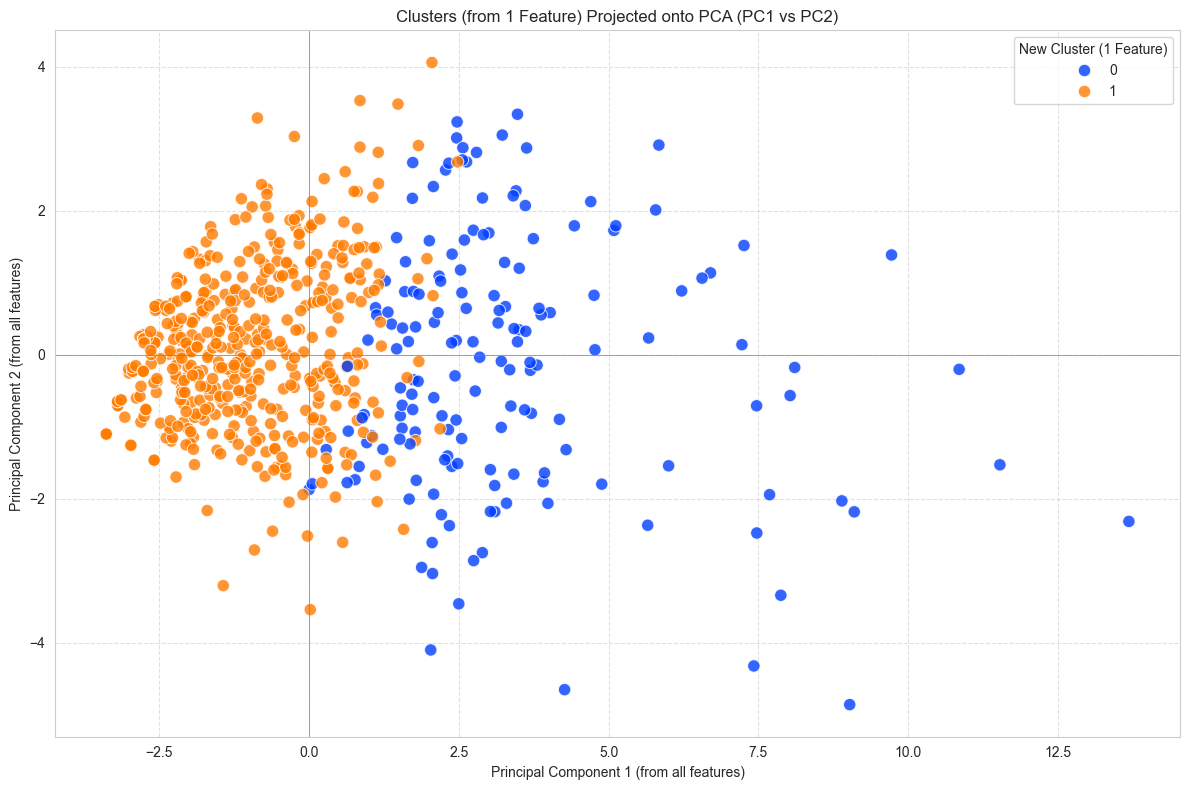

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת נתיבי הקבצים
# קובץ ה-PCA (עם PC1 ו-PC2) שיצרנו קודם
pca_data_path = "data/only_Q_outputs/combined/combined_pca_components.csv"

# קובץ תוצאות האשכול (עם עמודת 'cluster') מהפונקציה האחרונה שהרצת
# (הפונקציה cluster_on_selected_features שומרת לכאן, לא משנה בכמה עמודות השתמשת)
cluster_data_path = "data/only_Q_outputs/combined_no_pca/cluster_assignments_no_pca.csv"

# נתיב שמירה חדש לגרף
save_path = "data/only_Q_outputs/combined_no_pca/1_feature_cluster_on_pca_plot.png"

try:
    # 2. טעינת שני קבצי התוצאות
    pca_df = pd.read_csv(pca_data_path)
    cluster_df = pd.read_csv(cluster_data_path)

    # 3. מיזוג הקבצים
    # נמזג לפי המזהים הייחודיים של כל שורה (נבדק בנקודת זמן)
    merged_df = pd.merge(
        pca_df[['Subject_Code', 'timepoint', 'PC1', 'PC2']],
        cluster_df[['Subject_Code', 'timepoint', 'cluster']],
        on=['Subject_Code', 'timepoint']
    )

    # הפיכת עמודת האשכול לקטגוריה כדי להבטיח צבעים נכונים
    merged_df['cluster'] = merged_df['cluster'].astype('category')

    print("--- DataFrames merged successfully ---")
    print(merged_df.head())

    # 4. יצירת הגרף
    plt.figure(figsize=(12, 8))

    sns.scatterplot(
        data=merged_df,
        x='PC1',
        y='PC2',
        hue='cluster',  # <-- צביעה לפי האשכול מהניתוח החדש
        palette='bright',
        s=80,
        alpha=0.8,
        legend='full'
    )

    # 5. הוספת כותרות ושיפורים
    plt.title('Clusters (from 1 Feature) Projected onto PCA (PC1 vs PC2)')
    plt.xlabel('Principal Component 1 (from all features)')
    plt.ylabel('Principal Component 2 (from all features)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)
    plt.legend(title='New Cluster (1 Feature)')

    # 6. שמירת הגרף
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    print(f"\nהגרף נשמר בהצלחה ב: {save_path}")
    plt.show()

except FileNotFoundError as e:
    print(f"שגיאה: הקובץ לא נמצא. אנא ודא ששני הקבצים קיימים בנתיבים הנכונים.")
    print(e)
except Exception as e:
    print(f"אירעה שגיאה: {e}")

In [ ]:
import pandas as pd
import os

def filter_and_clean_csv(input_path, output_path, columns_to_keep):
    """
    טוען קובץ CSV, בוחר עמודות ספציפיות, מוחק שורות עם ערכים חסרים,
    ושומר את התוצאה לקובץ CSV חדש.

    Args:
        input_path (str): נתיב לקובץ ה-CSV המקורי (הגדול).
        output_path (str): נתיב לשמירת קובץ ה-CSV החדש והנקי.
        columns_to_keep (list): רשימת שמות העמודות שברצונך לשמור.
    """
    print(f"מתחיל בתהליך...")

    try:
        # 1. טעינת הנתונים
        # אנו משתמשים ב-usecols כדי לטעון רק את העמודות הנדרשות
        # זה חוסך המון זיכרון בקבצים גדולים
        print(f"טוען נתונים מ: {input_path}")
        df = pd.read_csv(input_path, usecols=columns_to_keep)
        original_rows = len(df)
        print(f"נתונים נטענו. צורה מקורית (רק עמודות נבחרות): {df.shape}")

    except FileNotFoundError:
        print(f"שגיאה: הקובץ לא נמצא בנתיב: {input_path}")
        return
    except ValueError as e:
        print(f"שגיאה: ייתכן שאחת העמודות שביקשת אינה קיימת. {e}")
        return
    except Exception as e:
        print(f"אירעה שגיאה בטעינת הקובץ: {e}")
        return

    # 2. מחיקת שורות עם ערכים חסרים (NaN)
    # dropna() מוחק כל שורה שיש בה לפחות NaN אחד
    print("מוחק שורות עם ערכים חסרים...")
    df_cleaned = df.dropna()
    cleaned_rows = len(df_cleaned)

    rows_dropped = original_rows - cleaned_rows
    print(f"נמחקו {rows_dropped} שורות.")
    print(f"צורה סופית: {df_cleaned.shape}")

    # 3. שמירת הקובץ החדש
    try:
        # וידוא שהתיקייה לשמירה קיימת
        output_dir = os.path.dirname(output_path)
        if output_dir: # אם הנתיב אינו ריק (לא שומר בתיקייה הנוכחית)
            os.makedirs(output_dir, exist_ok=True)

        # שמירה ללא עמודת האינדקס של פנדס
        df_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"\n✅ הקובץ הנקי נשמר בהצלחה ב: {output_path}")

    except Exception as e:
        print(f"אירעה שגיאה בשמירת הקובץ: {e}")

# ===================================================================
#           דוגמת שימוש
# ===================================================================

# 1. 💡 הגדר את העמודות שאתה רוצה לשמו
my_selected_columns = [
    'Subject_Code',
    'timepoint',
    'PHQ_1',
    'PHQ_2',
    'PHQ_9',
    'GAD7_1',
    'GAD7_7'
    # הוסף או שנה לרשימה הרצויה לך
]

# 2. 💡 הגדר את נתיבי הקבצים
input_file_path = 'combined.csv' # הקובץ המקורי שלך
output_file_path = 'data/cleaned/my_cleaned_data.csv' # לאן לשמור את התוצאה

# 3. קריאה לפונקציה
filter_and_clean_csv(
    input_path=input_file_path,
    output_path=output_file_path,
    columns_to_keep=my_selected_columns
)

In [53]:
import pandas as pd
import os

def filter_and_clean_excel(input_path, output_path, columns_to_keep, sheet_name=0, diff_columns=None):
    """
    טוען קובץ Excel (xlsx), בוחר עמודות, מוחק שורות חסרות,
    מחשב עמודות הפרש (אם סופקו), ושומר כ-CSV.

    Args:
        input_path (str): נתיב לקובץ ה-Excel.
        output_path (str): נתיב לשמירת קובץ ה-CSV החדש.
        columns_to_keep (list): רשימת העמודות לשמור (חייבת לכלול עמודות לחישוב).
        sheet_name (str or int): שם הגיליון (ברירת מחדל: 0).
        diff_columns (dict): מילון להגדרת עמודות הפרש.
                           פורמט: {'שם_עמודה_חדשה': ('עמודה_A', 'עמודה_B')}
                           החישוב יהיה: עמודה_A - עמודה_B
    """
    print(f"מתחיל בתהליך...")

    try:
        # 1. טעינת הנתונים מקובץ אקסל
        print(f"טוען נתונים מקובץ Excel: {input_path} (גיליון: {sheet_name})")
        df = pd.read_excel(
            input_path,
            sheet_name=sheet_name,
            usecols=columns_to_keep
        )
        original_rows = len(df)
        print(f"נתונים נטענו. צורה מקורית (רק עמודות נבחרות): {df.shape}")

    except FileNotFoundError:
        print(f"שגיאה: הקובץ לא נמצא בנתיב: {input_path}")
        return
    except ValueError as e:
        print(f"שגיאה: ייתכן שאחת העמודות שביקשת אינה קיימת. {e}")
        return
    except Exception as e:
        print(f"אירעה שגיאה בטעינת הקובץ: {e}")
        print("הערה: ודא שהספרייה 'openpyxl' מותקנת ('pip install openpyxl')")
        return

    # 2. מחיקת שורות עם ערכים חסרים (NaN)
    print("מוחק שורות עם ערכים חסרים...")
    df_cleaned = df.dropna()
    cleaned_rows = len(df_cleaned)

    rows_dropped = original_rows - cleaned_rows
    print(f"נמחקו {rows_dropped} שורות.")

    # 3. הוספת עמודות הפרש (החלק החדש)
    if diff_columns:
        print("מחשב עמודות הפרש...")
        # חשוב: השתמש ב-copy() כדי למנוע אזהרת SettingWithCopyWarning
        df_cleaned = df_cleaned.copy()

        for new_col, (col_a, col_b) in diff_columns.items():
            if col_a in df_cleaned.columns and col_b in df_cleaned.columns:

                # ודא שהעמודות הן מספריות לפני החיסור
                # errors='coerce' יהפוך טקסט (כמו "N/A") ל-NaN
                col_a_numeric = pd.to_numeric(df_cleaned[col_a], errors='coerce')
                col_b_numeric = pd.to_numeric(df_cleaned[col_b], errors='coerce')

                # בצע את החישוב
                df_cleaned[new_col] = col_a_numeric - col_b_numeric
                print(f"  נוצרה עמודה: {new_col} = {col_a} - {col_b}")
            else:
                print(f"  אזהרה: לא ניתן ליצור '{new_col}'. אחת מהעמודות ({col_a}, {col_b}) חסרה.")

        # 4. ניקוי נוסף
        # אם החישוב או ההמרה ל-numeric יצרו ערכי NaN חדשים, ננקה גם אותם
        # (זה שומר על הכלל שלך "למחוק שורות עם ערכים ריקים")
        final_cols_to_check = list(diff_columns.keys())
        df_cleaned = df_cleaned.dropna(subset=final_cols_to_check)
        final_rows_dropped = cleaned_rows - len(df_cleaned)

        if final_rows_dropped > 0:
            print(f"נמחקו {final_rows_dropped} שורות נוספות עקב חישוב הפרש (למשל, טקסט בעמודה).")

    print(f"צורה סופית: {df_cleaned.shape}")

    # 5. שמירת הקובץ החדש כ-CSV
    try:
        output_dir = os.path.dirname(output_path)
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)

        df_cleaned.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"\n✅ הקובץ הנקי נשמר בהצלחה ב: {output_path}")

    except Exception as e:
        print(f"אירעה שגיאה בשמירת הקובץ: {e}")

# ===================================================================
#           דוגמת שימוש
# ===================================================================

# 1. 💡 הגדר את *כל* העמודות שאתה צריך (גם לחישוב וגם לשמירה)
my_selected_columns = [
    'Subject_Code',
    'b_DES_average',
    'after_DES_total',
    'b_DERS_total',
    'after_DERS_total'
]

# 2. 💡 הגדר את חישובי ההפרש
#    פורמט: 'שם_חדש': ('ממנו_לחסר', 'מה_לחסר')
my_diff_calculations = {
    'diff_DES': ('after_DES_total', 'b_DES_average'),
    'diff_DERS': ('after_DERS_total', 'b_DERS_total')
}

# 3. 💡 הגדר את נתיבי הקבצים
input_file_path = 'data/q_data/Study_Questionnaire_Responses_October.xlsx'
output_file_path = 'data/only_Q_outputs/combined/regression_parameters.csv'

# 4. קריאה לפונקציה
filter_and_clean_excel(
    input_path=input_file_path,
    output_path=output_file_path,
    columns_to_keep=my_selected_columns,
    diff_columns=my_diff_calculations
)

מתחיל בתהליך...
טוען נתונים מקובץ Excel: data/q_data/Study_Questionnaire_Responses_October.xlsx (גיליון: 0)
נתונים נטענו. צורה מקורית (רק עמודות נבחרות): (208, 5)
מוחק שורות עם ערכים חסרים...
נמחקו 71 שורות.
מחשב עמודות הפרש...
  נוצרה עמודה: diff_DES = after_DES_total - b_DES_average
  נוצרה עמודה: diff_DERS = after_DERS_total - b_DERS_total
צורה סופית: (137, 7)

✅ הקובץ הנקי נשמר בהצלחה ב: data/only_Q_outputs/combined/regression_parameters.csv


In [55]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================================
#           חלק 1: הכנת הנתונים (טעינה, עיצוב מחדש, ומיזוג)
# ===================================================================

# נתיבי הקבצים
pca_data_path = "data/only_Q_outputs/combined/combined_pca_components.csv"
raw_data_path = "data/only_Q_outputs/combined/regression_parameters.csv"
# תיקייה לשמירת כל הגרפים
PLOTS_SAVE_DIR = "data/only_Q_outputs/combined/regression_plots_fixed_y"
# קובץ לשמירת טבלת הסיכום
SUMMARY_TABLE_SAVE_PATH = "data/only_Q_outputs/combined/regression_summary_table_fixed_y.csv"

# 💡💡💡
# --- הגדר כאן את הפרמטרים ---
# 💡💡💡

# 1. רשימת המשתנים *הקבועים* שאתה רוצה לנבא (Y)
#    (אלה צריכים להיות שמות עמודות מלאים מ-regression_parameters.csv)
Y_VARIABLES_TO_PREDICT = [
    'b_DES_average',
    'after_DES_total',
    "b_DERS_total",
    "after_DERS_total",
    "diff_DERS"
    "diff_DERS"
    # 💡 הוסף כאן עוד שמות עמודות
]

# 2. רשימת נקודות הזמן של PC1 (X)
PC1_TIMEPOINTS = ['b', 't1', 't2', 't3', 'after']

try:
    # --- 1א: הכנת נתוני ה-X (PC1) ---
    print("Loading and pivoting PC1 data...")
    pca_df_long = pd.read_csv(pca_data_path)

    # הפיכת הטבלה "הארוכה" ל"רחבה"
    pca_df_wide = pca_df_long.pivot(
        index='Subject_Code',
        columns='timepoint',
        values='PC1'
    )
    # שינוי שמות העמודות (מ-'b' ל-'PC1_b')
    pca_df_wide.columns = [f'PC1_{col}' for col in pca_df_wide.columns]

    # --- 1ב: הכנת נתוני ה-Y ---
    print("Loading Y variables...")
    # טעינת רק העמודות הרלוונטיות
    columns_to_load = ['Subject_Code'] + Y_VARIABLES_TO_PREDICT
    raw_df = pd.read_csv(raw_data_path, usecols=lambda c: c in columns_to_load)
    # raw_df מכיל כעת רק שורה אחת לכל נבדק (בהנחה ש-regression_parameters.csv בנוי כך)

    # --- 1ג: מיזוג ---
    df_for_regression = pd.merge(
        pca_df_wide.reset_index(), # (Subject_Code | PC1_b | PC1_t1 ...)
        raw_df,                    # (Subject_Code | b_DES_average | ...)
        on='Subject_Code'
    )

    print("--- Data successfully merged and pivoted ---")
    print(df_for_regression.head())

    # יצירת תיקיית הפלט לגרפים
    os.makedirs(PLOTS_SAVE_DIR, exist_ok=True)

except FileNotFoundError:
    print("שגיאה: אחד מקובצי הנתונים לא נמצא. לא ניתן להמשיך.")
    df_for_regression = None
except ValueError as e:
    print(f"שגיאה בטעינת הנתונים. ייתכן שאחת העמודות ב-Y_VARIABLES_TO_PREDICT אינה קיימת. {e}")
    df_for_regression = None
except Exception as e:
    print(f"אירעה שגיאה: {e}")
    df_for_regression = None

# ===================================================================
#           חלק 2: הרצת הניתוח בלולאה
# ===================================================================

# הגדרות נוספות
N_SPLITS = 5
RANDOM_STATE = 42
all_results_list = []

if df_for_regression is not None:

    # --- התחלת הלולאות ---
    for y_col in Y_VARIABLES_TO_PREDICT:
        print(f"\n=======================================================")
        print(f"  Processing Y-Variable: {y_col}")
        print(f"=======================================================")

        for tp in PC1_TIMEPOINTS:

            # 3. בניית שם המשתנה המנבא (X)
            X_COL_NAME = f'PC1_{tp}'

            if X_COL_NAME not in df_for_regression.columns:
                print(f"--- Skipping: Column '{X_COL_NAME}' not found.")
                continue

            print(f"\n--- Running: '{y_col}' ~ '{X_COL_NAME}' ---")

            # 4. הכנת X ו-Y, וניקוי ערכים חסרים
            data_clean = df_for_regression[[X_COL_NAME, y_col]].dropna()

            if len(data_clean) < N_SPLITS * 2:
                print(f"  Skipping: Not enough data (N={len(data_clean)})")
                continue

            X = data_clean[[X_COL_NAME]]
            y = data_clean[y_col]

            # 5. שלב א': הערכת המודל (אימות צולב)
            model_cv = LinearRegression()
            kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
            scoring = {'r_squared': 'r2', 'neg_mse': 'neg_mean_squared_error'}
            cv_scores = cross_validate(model_cv, X, y, cv=kfold, scoring=scoring)

            mean_r2 = np.mean(cv_scores['test_r_squared'])
            std_r2 = np.std(cv_scores['test_r_squared'])
            mean_rmse = np.sqrt(-np.mean(cv_scores['test_neg_mse']))
            print(f"  R² (CV): {mean_r2:.3f} | RMSE (CV): {mean_rmse:.3f} | N = {len(y)}")

            # 6. שלב ב': אימון מודל סופי (לקבלת מקדמים)
            model_final = LinearRegression()
            model_final.fit(X, y)
            alpha = model_final.intercept_
            beta = model_final.coef_[0]
            print(f"  Alpha: {alpha:.4f} | Beta: {beta:.4f}")

            # 7. שלב ג': שרטוט הגרף
            plt.figure(figsize=(10, 6))
            sns.regplot(data=data_clean, x=X_COL_NAME, y=y_col,
                        line_kws={'color': 'red', 'linestyle': '--'},
                        scatter_kws={'alpha': 0.7})

            plt.title(f'Regression: {y_col} vs. {X_COL_NAME}')
            plt.xlabel(f'Principal Component 1 (Timepoint: {tp})')
            plt.ylabel(f'{y_col}')
            plt.grid(True, linestyle='--', alpha=0.6)

            plt.text(0.05, 0.95, f'$R^2$ (from CV) = {mean_r2:.3f}\nRMSE (from CV) = {mean_rmse:.3f}',
                     transform=plt.gca().transAxes,
                     verticalalignment='top',
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

            plt.tight_layout()

            # שמירת הגרף עם שם ייחודי
            plot_save_path = os.path.join(PLOTS_SAVE_DIR, f"reg_{y_col}_vs_PC1_{tp}.png")
            plt.savefig(plot_save_path, dpi=100)
            plt.close()
            print(f"  Plot saved to {plot_save_path}")

            # 8. שמירת התוצאות לרשימה
            all_results_list.append({
                'Y_Variable': y_col,
                'X_Variable (PC1 Timepoint)': tp,
                'R_Squared': mean_r2,
                'R_Squared_Std': std_r2,
                'RMSE': mean_rmse,
                'Alpha_B0': alpha,
                'Beta_B1': beta,
                'N': len(y)
            })

    print("\n\n--- כל הניתוחים הסתיימו ---")

    # ===================================================================
    #           חלק 3: יצירת טבלת סיכום
    # ===================================================================

    if all_results_list:
        summary_df = pd.DataFrame(all_results_list)
        summary_df = summary_df.sort_values(by=['Y_Variable', 'X_Variable (PC1 Timepoint)'])

        print("\n--- טבלת סיכום סופית ---")

        summary_df.to_csv(SUMMARY_TABLE_SAVE_PATH, index=False, encoding='utf-8-sig')
        print(f"\n✅ טבלת הסיכום נשמרה ב: {SUMMARY_TABLE_SAVE_PATH}")
    else:
        print("\n--- לא נוצרו תוצאות ---")

else:
    print("הניתוח לא רץ כי הנתונים לא נטענו כראוי.")